# AdventureGame Evaluation
This notebook produces tables and plots to analyse AdventureGame results. All plots and tables appearing in the AdventureGame paper are created using the contained code.

In [1]:
import sys
# sys.path.append('..')

from pathlib import Path

import json
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import ListedColormap
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Polygon
from numpy.ma.extras import average

import evaluation.evalutils as utils
from evaluation.makingtables import build_dispersion_table
import evaluation.clemmetrics as clemmetrics

Choose path for the .csv with the raw scores. This is created after running ```bencheval.py```.

In [2]:
RAW_PATH = Path('results/raw.csv')
raw_df = pd.read_csv(RAW_PATH, index_col=0)

Full results dataframe:

In [3]:
raw_df

,game,model,experiment,episode,metric,value
0,adventuregame,claude-3-7-sonnet-20250219-t0.0--claude-3-7-so...,0_home_deliver_three_basic_easy,episode_0,Violated Request Count,0.0
1,adventuregame,claude-3-7-sonnet-20250219-t0.0--claude-3-7-so...,0_home_deliver_three_basic_easy,episode_0,Parsed Request Count,10.0
2,adventuregame,claude-3-7-sonnet-20250219-t0.0--claude-3-7-so...,0_home_deliver_three_basic_easy,episode_0,Request Count,10.0
3,adventuregame,claude-3-7-sonnet-20250219-t0.0--claude-3-7-so...,0_home_deliver_three_basic_easy,episode_0,Request Success Ratio,1.0
4,adventuregame,claude-3-7-sonnet-20250219-t0.0--claude-3-7-so...,0_home_deliver_three_basic_easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
84583,adventuregame,Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder...,9_home_deliver_three_planning_preexplore_hard,episode_5,Played,0.0
84584,adventuregame,Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder...,9_home_deliver_three_planning_preexplore_hard,episode_6,Played,0.0
84585,adventuregame,Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder...,9_home_deliver_three_planning_preexplore_hard,episode_7,Played,0.0
84586,adventuregame,Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder...,9_home_deliver_three_planning_preexplore_hard,episode_8,Played,0.0


Dictionaries for converting full model, experiment and score/metric names to compact names:

In [202]:
model_name_dict = {
    # 'gemma-2-9b-it-GGUF-q5-t0.0--gemma-2-9b-it-GGUF-q5-t0.0': "gemma-2-9b-it-q5",
    # 'gemma-7b-it-Groq-t0.0--gemma-7b-it-Groq-t0.0': "gemma-7b-it",
    # 'gemma2-9b-it-Groq-t0.0--gemma2-9b-it-Groq-t0.0': "gemma2-9b-it",
    # 'Llama-3-70B-Instruct-Groq-t0.0--Llama-3-70B-Instruct-Groq-t0.0': "Llama-3-70B-Instruct",
    # 'Llama-3-8B-Instruct-Groq-t0.0--Llama-3-8B-Instruct-Groq-t0.0': "Llama-3-8B-Instruct",
    # 'llama-3.1-70b-versatile-Groq-t0.0--llama-3.1-70b-versatile-Groq-t0.0': "Llama-3.1-70b-Instruct",
    # 'llama-3.1-8b-instant-Groq-t0.0--llama-3.1-8b-instant-Groq-t0.0': "Llama-3.1-8b-Instruct",
    # 'LLaMA2-13B-Tiefighter-t0.0--LLaMA2-13B-Tiefighter-t0.0': "LLaMA2-13B-Tiefighter",
    # 'Meta-Llama-3.1-405B-Instruct-Turbo-TogetherAI-t0.0--Meta-Llama-3.1-405B-Instruct-Turbo-TogetherAI-t0.0': "Llama-3.1-405B-Instruct",
    # 'Mistral-Large-Instruct-2407-t0.0--Mistral-Large-Instruct-2407-t0.0': "Mistral-Large-Instruct-2407",
    # 'openchat_3.5-GGUF-q5-t0.0--openchat_3.5-GGUF-q5-t0.0': "openchat3.5-GGUF-q5",
    'openchat_3.5-GGUF-q8-t0.0--openchat_3.5-GGUF-q8-t0.0': 'openchat3.5-Q8',
    'openchat_3.5-t0.0--openchat_3.5-t0.0': "openchat3.5",
    # 'Qwen1.5-72B-Chat-t0.0--Qwen1.5-72B-Chat-t0.0': "Qwen1.5-72B-Chat",
    'Qwen2-72B-Instruct-t0.0--Qwen2-72B-Instruct-t0.0': "Qwen2-72B",
    'Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0': 'Llama-3.1-8B',
    'Meta-Llama-3-8B-Instruct-t0.0--Meta-Llama-3-8B-Instruct-t0.0': 'Llama-3-8B',
    'Qwen2.5-7B-Instruct-t0.0--Qwen2.5-7B-Instruct-t0.0': 'Qwen2.5-7B',
    'Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0': 'Qwen2.5-32B',
    'Qwen2.5-Coder-7B-Instruct-t0.0--Qwen2.5-Coder-7B-Instruct-t0.0': 'Qwen2.5C-7B',
    'Qwen2.5-72B-Instruct-t0.0--Qwen2.5-72B-Instruct-t0.0': 'Qwen2.5-72B',
    'Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0': 'Llama-3.3-70B',
    'Meta-Llama-3.1-70B-Instruct-t0.0--Meta-Llama-3.1-70B-Instruct-t0.0': 'Llama-3.1-70B',
    'Sky-T1-32B-Preview-t0.0--Sky-T1-32B-Preview-t0.0': 'Sky-T1-32B',
    'llama-3.1-405b-t0.0--llama-3.1-405b-t0.0': 'Llama-3.1-405B',
    'gpt-4o-2024-08-06-t0.0--gpt-4o-2024-08-06-t0.0': 'GPT-4o',
    'claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0': 'Claude-3.5',
    'claude-3-7-sonnet-20250219-t0.0--claude-3-7-sonnet-20250219-t0.0': 'Claude-3.7',
    'qwen-max-t0.0--qwen-max-t0.0': 'Qwen-max',
    'gemini-2.0-flash-exp-t0.0--gemini-2.0-flash-exp-t0.0': 'Gemini-2.0',
    'deepseek-v3-t0.0--deepseek-v3-t0.0': 'DeepSeek-V3',
    'o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0': 'o3-mini'
}

top_models = [
    'o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0',
    'claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0',
    'gpt-4o-2024-08-06-t0.0--gpt-4o-2024-08-06-t0.0',
    'Meta-Llama-3.1-70B-Instruct-t0.0--Meta-Llama-3.1-70B-Instruct-t0.0',
    'Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0',
    'Qwen2-72B-Instruct-t0.0--Qwen2-72B-Instruct-t0.0',
    'Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0',
    'Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0',
    'Qwen2.5-72B-Instruct-t0.0--Qwen2.5-72B-Instruct-t0.0'
    ]

final_models = [
    'claude-3-7-sonnet-20250219-t0.0--claude-3-7-sonnet-20250219-t0.0',
    'o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0',
    'gpt-4o-2024-08-06-t0.0--gpt-4o-2024-08-06-t0.0',
    # 'qwen-max-t0.0--qwen-max-t0.0',
    'Meta-Llama-3.1-70B-Instruct-t0.0--Meta-Llama-3.1-70B-Instruct-t0.0',
    'Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0',
    'deepseek-v3-t0.0--deepseek-v3-t0.0',
    # 'llama-3.1-405b-t0.0--llama-3.1-405b-t0.0',
    'Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0',
    # 'gemini-2.0-flash-exp-t0.0--gemini-2.0-flash-exp-t0.0',
    'Qwen2-72B-Instruct-t0.0--Qwen2-72B-Instruct-t0.0',
    'Qwen2.5-72B-Instruct-t0.0--Qwen2.5-72B-Instruct-t0.0',
    'Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0',
    # 'Sky-T1-32B-Preview-t0.0--Sky-T1-32B-Preview-t0.0'
]

experiment_short_name_dict = {
    '0_home_deliver_three_basic_easy': "basic-easy",
    # '1_home_deliver_three_basic_preexplore_easy': "basic-easy-preexplore",
    '1_home_deliver_three_basic_preexplore_easy': "basic-easy-preexp",
    '2_home_deliver_three_planning_easy': "planning-easy",
    '3_home_deliver_three_planning_preexplore_easy': "planning-easy-preexplore",
    '4_home_deliver_three_basic_easy_invlimittwo': "basic-easy-invlimit",
    '5_home_deliver_three_planning_easy_invlimittwo': "planning-easy-invlimit",
    '6_home_deliver_three_basic_hard': "basic-hard",
    # '7_home_deliver_three_basic_preexplore_hard': "basic-hard-preexplore",
    '7_home_deliver_three_basic_preexplore_hard': "basic-hard-preexp",
    '8_home_deliver_three_planning_hard': "planning-hard",
    '9_home_deliver_three_planning_preexplore_hard': "planning-hard-preexplore",
    '10_home_deliver_three_basic_hard_invlimittwo': "basic-hard-invlimit",
    '11_home_deliver_three_planning_hard_invlimittwo': "planning-hard-invlimit",
    '12_new-words_home-delivery_easy_basic_easy': "new-words-easy",
    '13_new-words_home-delivery_medium_basic_medium': "new-words-medium",
    '14_new-words_created_basic_hard': "new-words-hard",
}

metric_name_dict = {
    'taking_from_inventory': "taking from inventory",
    'other_room_argument': "interacting with other room",
    'not_room_type': "going to non-existent room",
    'going_to_current_room': "going to current room",
    'no_exit_to': "going to non-adjacent room",
    'multiple_exits_to': "ambiguous traversal",
    'entity_already_inventory': "entity already in inventory",
    'thing_arg1_room': "first entity is room",
    'entity_not_accessible': "entity not accessible",
    'multiple_entity_ambiguity': "ambiguous entity",
    'thing_arg2_room': "second entity is room",
    'pre_state_mismatch': "main condition not fact",
    'action_parsing_fail': "parsing failure",
    'action_resolution_fail': "resolution failure",
    'lark_exception': "out of grammar",
    'malformed_command': "malformed command",
    'undefined_action_verb': "undefined action verb",
    'undefined_action': "undefined action type",
    'undefined_repr_str': "undefined noun",
    'manipulating_room': "manipulating room",
    'undefined_argument_type': "undefined antecedent",
    'successful_actions': "successful actions",
    'finish_speed': "finish speed",
    'domain_trait_type_mismatch': "domain mismatch",
    'domain_type_discrepancy': "domain discrepancy",
    'world_state_discrepancy': "world state discrepancy",
    'entity_state_mismatch': "entity state mismatch",
    'entity_trait_mismatch': "entity trait mismatch",
    'inventory_limit_exceeded': "inventory limit exceeded"
}

Dataframe containing only AdventureGame results (needed in case AdventureGame was run along with other clemgames), with short model and experiment names:

In [5]:
game_df = raw_df[raw_df.game == 'adventuregame']
game_df = game_df.replace(model_name_dict).replace(experiment_short_name_dict)
game_df

,game,model,experiment,episode,metric,value
0,adventuregame,Claude-3.7,basic-easy,episode_0,Violated Request Count,0.0
1,adventuregame,Claude-3.7,basic-easy,episode_0,Parsed Request Count,10.0
2,adventuregame,Claude-3.7,basic-easy,episode_0,Request Count,10.0
3,adventuregame,Claude-3.7,basic-easy,episode_0,Request Success Ratio,1.0
4,adventuregame,Claude-3.7,basic-easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
84583,adventuregame,Qwen2.5-32B,planning-hard-preexplore,episode_5,Played,0.0
84584,adventuregame,Qwen2.5-32B,planning-hard-preexplore,episode_6,Played,0.0
84585,adventuregame,Qwen2.5-32B,planning-hard-preexplore,episode_7,Played,0.0
84586,adventuregame,Qwen2.5-32B,planning-hard-preexplore,episode_8,Played,0.0


## Overall benchmark scores

In [6]:
# read the clem scores
RESULTS_PATH = Path('results/results.csv')
clem_df = pd.read_csv(RESULTS_PATH, index_col=0)

Full overall score dataframe (useful in case other clemgames were run along with AdventureGame):

In [7]:
clem_df = clem_df.rename(model_name_dict)
clem_df

,"-, clemscore","adventuregame, % Played","adventuregame, Quality Score","adventuregame, Quality Score (std)","all, Average % Played","all, Average Quality Score"
Llama-3.3-70B,40.08,92.50,43.33,49.66,92.50,43.33
Llama-3.1-70B,43.84,89.17,49.17,50.10,89.17,49.17
Llama-3.1-8B,8.22,39.92,20.59,40.52,39.92,20.59
Qwen2-72B,15.93,55.42,28.75,45.35,55.42,28.75
Qwen2.5-72B,11.25,52.92,21.25,40.99,52.92,21.25
Qwen2.5-32B,11.98,47.92,25.00,43.39,47.92,25.00
Claude-3.7,86.36,97.92,88.19,32.38,97.92,88.19
DeepSeek-V3,39.75,85.42,46.53,50.05,85.42,46.53
GPT-4o,52.73,93.75,56.25,49.78,93.75,56.25
o3-mini,68.73,86.81,79.17,40.75,86.81,79.17


Overview dataframe, omitting averages for 'all games' (assumes only AdventureGame results present):

In [8]:
overview_df = clem_df.rename(model_name_dict).drop(columns=["all, Average % Played", "all, Average Quality Score", "adventuregame, Quality Score (std)"]).sort_values(by='-, clemscore', ascending=False)
overview_short_columns = {"-, clemscore": "clemscore", "adventuregame, % Played": "% Played", "adventuregame, Quality Score": "Quality Score", "adventuregame, Quality Score (std)": "Quality Score (std)"}
overview_df = overview_df.rename(columns=overview_short_columns)
overview_df

,clemscore,% Played,Quality Score
Claude-3.7,86.36,97.92,88.19
o3-mini,68.73,86.81,79.17
GPT-4o,52.73,93.75,56.25
Llama-3.1-70B,43.84,89.17,49.17
Llama-3.3-70B,40.08,92.50,43.33
DeepSeek-V3,39.75,85.42,46.53
Qwen2-72B,15.93,55.42,28.75
Qwen2.5-32B,11.98,47.92,25.00
Qwen2.5-72B,11.25,52.92,21.25
Llama-3.1-8B,8.22,39.92,20.59


In [9]:
# get overall goal%:
goals_df = game_df.drop(columns=["game"])
# goals_df = goals_df.query('metric in ["Main Score", "Played", "achieved_goal_rating"]')
goals_df = goals_df.query('metric in ["achieved_goal_rating"]')

# goals_df = goals_df.query("model in ['o3-mini', 'Claude-3.5', 'Llama-3.1-70B', 'Qwen2.5-32B', 'GPT-4o']")

# goals_df = build_dispersion_table(['model', 'experiment', 'metric'], goals_df)
goals_df = build_dispersion_table(['model', 'metric'], goals_df)
# goals_df = build_dispersion_table(['model'], goals_df)

goals_df = goals_df.drop(columns=["var", "median", "max", "min", "skew", "std"])

goals_df = goals_df.rename({"achieved_goal_rating": "% Goals"})

goals_df = pd.pivot_table(goals_df, index=['model'], columns='metric')

# goals_df = goals_df.rename({'mean': '% Goals'})

goals_df[('metric', '% Goals')] = goals_df[('mean', '% Goals')]

goals_df = goals_df.drop(columns=[('mean', '% Goals')])

goals_df

,metric
metric,% Goals
model,
Claude-3.7,90.509259
DeepSeek-V3,64.814815
GPT-4o,75.925926
Llama-3.1-70B,66.805556
Llama-3.1-8B,35.714286
Llama-3.3-70B,64.444444
Qwen2-72B,47.500000
Qwen2.5-32B,47.777778


In [10]:
# combined_df = pd.concat([overview_df, goals_col.rename("% Goals")], axis=1)
# combined_df = pd.concat([overview_df, goals_col], axis=1)
combined_df = pd.concat([overview_df, goals_df], axis=1)
combined_df = combined_df.rename({'mean': '% Goals'})
combined_df

,clemscore,% Played,Quality Score,"(metric, % Goals)"
Claude-3.7,86.36,97.92,88.19,90.509259
o3-mini,68.73,86.81,79.17,85.879630
GPT-4o,52.73,93.75,56.25,75.925926
Llama-3.1-70B,43.84,89.17,49.17,66.805556
Llama-3.3-70B,40.08,92.50,43.33,64.444444
DeepSeek-V3,39.75,85.42,46.53,64.814815
Qwen2-72B,15.93,55.42,28.75,47.500000
Qwen2.5-32B,11.98,47.92,25.00,47.777778
Qwen2.5-72B,11.25,52.92,21.25,44.861111
Llama-3.1-8B,8.22,39.92,20.59,35.714286


In [11]:
combined_df.to_html("results/adventuregame_overview_table_goals.html")

In [12]:
combined_overview_styled = combined_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
# ], overwrite=False).format(subset="clemscore", precision=1).format(subset="% Played", precision=1).format(subset="Quality Score", precision=1).format(subset="('metric', '% Goals')", precision=1)
], overwrite=False).format(precision=1)
combined_overview_styled.to_latex('results/adventuregame_overview_table_goals.tex')

In [13]:
overview_df.to_html("results/adventuregame_overview_table.html")
overview_df.to_csv("results/adventuregame_overview_table.csv")

In [14]:
overview_styled = overview_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(subset="clemscore", precision=1).format(subset="% Played", precision=1).format(subset="Quality Score", precision=1)
overview_styled.to_latex('results/adventuregame_overview_table.tex')

Model comparison stacked bar plot:

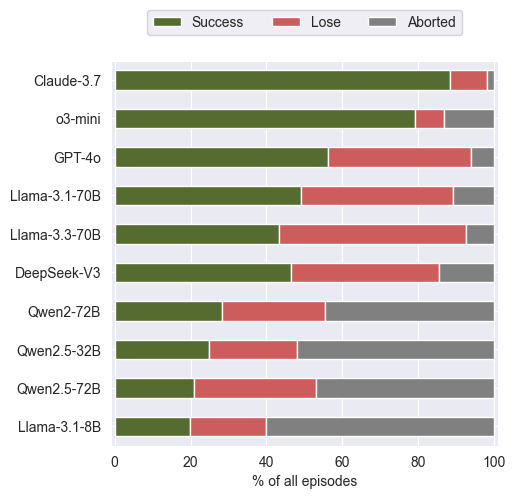

In [15]:
STACK_COLORS = ['darkolivegreen', 'indianred', 'gray']

df_aux = raw_df[raw_df.metric.isin(utils.GAMEPLAY_METRICS)]

df_aux = df_aux.replace(model_name_dict)

df_aux = df_aux[~df_aux.model.str.contains('openchat')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5C-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Llama-3-8B')]


clem_df_cull = clem_df[~clem_df.index.str.contains('openchat')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5C-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Llama-3-8B')]


df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df_cull.sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=3)
plt.xlabel('% of all episodes')
plt.xlim(-1, 101)
plt.ylabel('')

plt.savefig("results/episode_overview_stack.pdf", format="pdf", bbox_inches="tight")

plt.show()

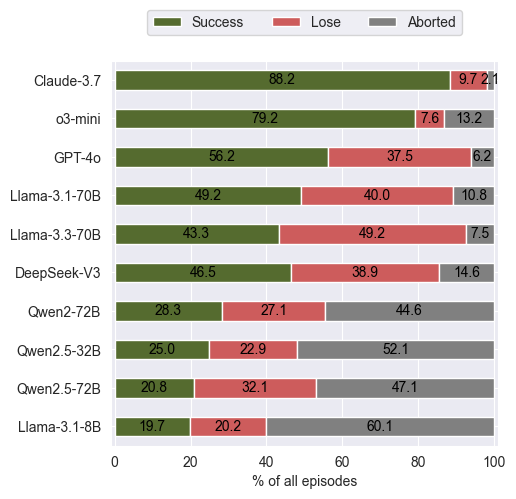

In [16]:
STACK_COLORS = ['darkolivegreen', 'indianred', 'gray']

df_aux = raw_df[raw_df.metric.isin(utils.GAMEPLAY_METRICS)]

df_aux = df_aux.replace(model_name_dict)

df_aux = df_aux[~df_aux.model.str.contains('openchat')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5C-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Llama-3-8B')]


clem_df_cull = clem_df[~clem_df.index.str.contains('openchat')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5C-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Llama-3-8B')]


df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df_cull.sort_values(by='-, clemscore').index
percs = percs.reindex(order)

stacks = percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))

# print(stacks.__dict__)
# plt.bar_label(stacks, label_type='center')
# stacks.bar_label(percs)
for bar in stacks.containers:
    labels = [np.round(v.get_width(), 1) for v in bar]
    # labels = [v for v in bar]
    # for v in bar:
    #    print(v)
    #    print(v.get_width())
    #    print(type(v.get_width()))
    stacks.bar_label(bar, labels=labels, label_type='center', color='black')
    # stacks.bar_label(bar, label_type='center', color='black')


plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=3)
plt.xlabel('% of all episodes')
plt.xlim(-1, 101)
plt.ylabel('')

plt.savefig("results/episode_overview_stack.pdf", format="pdf", bbox_inches="tight")

plt.show()

Bar plot with sorted clemscores:

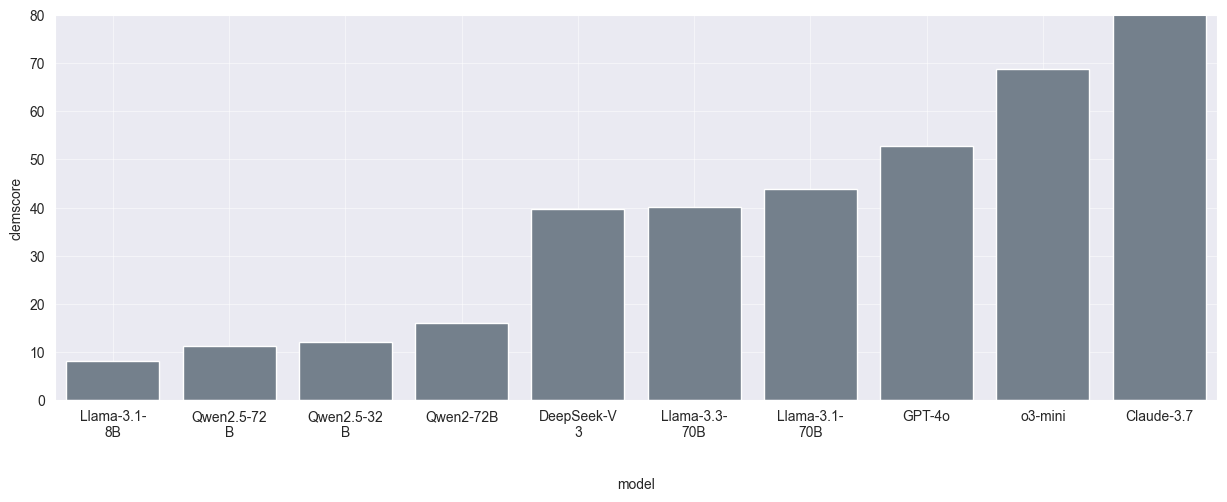

In [17]:
clem_aux = clem_df.sort_values(by='-, clemscore').reset_index(names='model').replace(model_name_dict)
# warning, if models have matching names up the limit, results will be wrongly merged!
clem_aux['model'] = clem_aux['model'].apply(lambda x: f'{x[:10]}\n{x[10:20]}\n{x[20:30]}\n{x[30:]}')

fig = plt.figure(figsize=(15, 5))
sns.barplot(clem_aux, x='model', y='-, clemscore', color='slategray')
# plt.ylim(-5, 105)
plt.ylim(0, 80)
plt.ylabel('clemscore')
plt.grid(alpha=0.5)
plt.show()

Omit models for which all episodes were aborted due to not following prompted format for detail analysis:

In [18]:
all_abort_models = ["LLaMA2-13B-Tiefighter"]
game_df = game_df.query('model not in ["LLaMA2-13B-Tiefighter"]')
game_df

,game,model,experiment,episode,metric,value
0,adventuregame,Claude-3.7,basic-easy,episode_0,Violated Request Count,0.0
1,adventuregame,Claude-3.7,basic-easy,episode_0,Parsed Request Count,10.0
2,adventuregame,Claude-3.7,basic-easy,episode_0,Request Count,10.0
3,adventuregame,Claude-3.7,basic-easy,episode_0,Request Success Ratio,1.0
4,adventuregame,Claude-3.7,basic-easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
84583,adventuregame,Qwen2.5-32B,planning-hard-preexplore,episode_5,Played,0.0
84584,adventuregame,Qwen2.5-32B,planning-hard-preexplore,episode_6,Played,0.0
84585,adventuregame,Qwen2.5-32B,planning-hard-preexplore,episode_7,Played,0.0
84586,adventuregame,Qwen2.5-32B,planning-hard-preexplore,episode_8,Played,0.0


## Failure metrics
### Failures by IF interpreter phase

In [19]:
failures_by_phase_df = game_df.query('metric in ["action_parsing_fail", "action_resolution_fail"]')
failures_by_phase_df

,game,model,experiment,episode,metric,value
5,adventuregame,Claude-3.7,basic-easy,episode_0,action_parsing_fail,0.0
6,adventuregame,Claude-3.7,basic-easy,episode_0,action_resolution_fail,0.0
46,adventuregame,Claude-3.7,basic-easy,episode_1,action_parsing_fail,0.0
47,adventuregame,Claude-3.7,basic-easy,episode_1,action_resolution_fail,0.0
87,adventuregame,Claude-3.7,basic-easy,episode_10,action_parsing_fail,0.0
...,...,...,...,...,...,...
82457,adventuregame,Qwen2.5-32B,planning-hard-preexplore,episode_7,action_resolution_fail,11.0
82497,adventuregame,Qwen2.5-32B,planning-hard-preexplore,episode_8,action_parsing_fail,1.0
82498,adventuregame,Qwen2.5-32B,planning-hard-preexplore,episode_8,action_resolution_fail,14.0
82538,adventuregame,Qwen2.5-32B,planning-hard-preexplore,episode_9,action_parsing_fail,1.0


Bar plot showing failures by phase for all models over all experiments:

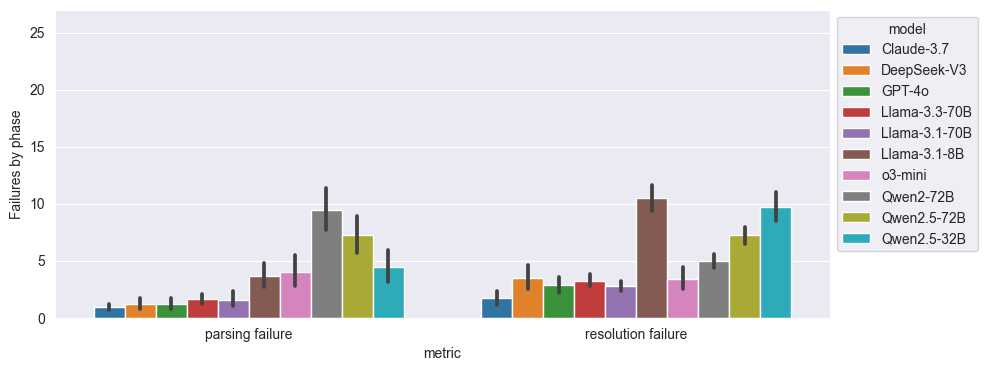

In [20]:
fig, ax = plt.subplots(figsize=(10, 4))

g = sns.barplot(failures_by_phase_df.replace(metric_name_dict),
                x='metric',
                y='value',
                hue='model',
                ax=ax)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
plt.ylim(0, 27)
plt.ylabel("Failures by phase")

plt.show()

Dataframe with parsed request counts, ie actions passed to the IF interpreter (used to calculate failure ratios):

In [21]:
parsed_df = game_df[game_df.metric == "Parsed Request Count"].groupby(["model"]).sum()
parsed_df = parsed_df.drop(columns=["game", 'experiment', 'episode', 'metric'])
parsed_df

,value
model,
Claude-3.7,3016.0
DeepSeek-V3,3569.0
GPT-4o,3377.0
Llama-3.1-70B,5750.0
Llama-3.1-8B,8192.0
Llama-3.3-70B,5823.0
Qwen2-72B,7649.0
Qwen2.5-32B,8676.0
Qwen2.5-72B,8463.0


Counts of failures by phase for all models over all experiments:

In [22]:
failures_by_phase_counts = failures_by_phase_df.replace(metric_name_dict).groupby(['model', 'metric']).sum()
failures_by_phase_counts = failures_by_phase_counts.drop(columns=["game", 'experiment', 'episode'])
failures_by_phase_counts

value
model         metric                    
Claude-3.7    parsing failure      133.0
              resolution failure   243.0
DeepSeek-V3   parsing failure      168.0
              resolution failure   502.0
GPT-4o        parsing failure      167.0
              resolution failure   415.0
Llama-3.1-70B parsing failure      380.0
              resolution failure   660.0
Llama-3.1-8B  parsing failure      877.0
              resolution failure  2497.0
Llama-3.3-70B parsing failure      388.0
              resolution failure   779.0
Qwen2-72B     parsing failure     2272.0
              resolution failure  1197.0
Qwen2.5-32B   parsing failure     1059.0
              resolution failure  2332.0
Qwen2.5-72B   parsing failure     1742.0
              resolution failure  1730.0
o3-mini       parsing failure      581.0
              resolution failure   494.0

Ratios of failures by phase for all models over all experiments (calculated by dividing failures counts by parsed request counts):

In [23]:
failures_by_phase_ratios = failures_by_phase_counts / parsed_df
failures_by_phase_ratios

value
model         metric                      
Claude-3.7    parsing failure     0.044098
              resolution failure  0.080570
DeepSeek-V3   parsing failure     0.047072
              resolution failure  0.140656
GPT-4o        parsing failure     0.049452
              resolution failure  0.122890
Llama-3.1-70B parsing failure     0.066087
              resolution failure  0.114783
Llama-3.1-8B  parsing failure     0.107056
              resolution failure  0.304810
Llama-3.3-70B parsing failure     0.066632
              resolution failure  0.133780
Qwen2-72B     parsing failure     0.297032
              resolution failure  0.156491
Qwen2.5-32B   parsing failure     0.122061
              resolution failure  0.268787
Qwen2.5-72B   parsing failure     0.205837
              resolution failure  0.204419
o3-mini       parsing failure     0.157880
              resolution failure  0.134239

Overview/model comparison stacked bar plot for successful actions and failures by phase:

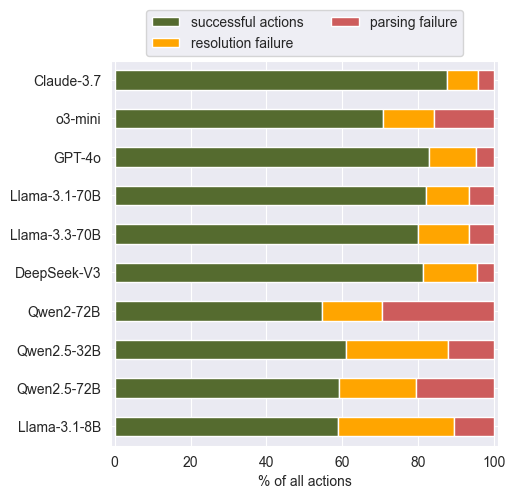

In [24]:
STACK_COLORS = ['darkolivegreen', 'orange', 'indianred']

phase_failures = ["action_parsing_fail", "action_resolution_fail", "successful_actions"]

df_aux = game_df[game_df.metric.isin(phase_failures)]
df_aux = df_aux.replace(metric_name_dict)


df_aux = df_aux[~df_aux.model.str.contains('openchat')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5C-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Llama-3-8B')]


clem_df_cull = clem_df[~clem_df.index.str.contains('openchat')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5C-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Llama-3-8B')]


df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df_cull.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2)
plt.xlabel('% of all actions')
plt.xlim(-1, 101)
plt.ylabel('')

plt.savefig("results/action_overview_stack.pdf", format="pdf", bbox_inches="tight")

plt.show()

### Parsing failures
Dataframe with parsing failure counts/ratios:
Note: While "undefined_action" and "undefined_argument_type" did not occur in the v1 results, they are implemented, and thus not omitted here.

In [25]:
parsing_failures_df = game_df.query('metric in ["lark_exception", "malformed_command", "undefined_action", "undefined_action_verb", "undefined_repr_str", "undefined_argument_type"]')
parsing_failures_df = parsing_failures_df.replace(metric_name_dict)
parsing_failures_counts = parsing_failures_df.groupby(['model', 'metric']).sum()
parsing_failures_counts = parsing_failures_counts.drop(columns=["game", 'experiment', 'episode'])
parsing_failures_counts['Ratio'] = parsing_failures_counts / parsed_df
parsing_failures_counts = parsing_failures_counts.rename(columns={"value": "Count"})
parsing_failures_counts

Count     Ratio
model         metric                                 
Claude-3.7    malformed command        56.0  0.018568
              out of grammar            0.0  0.000000
              undefined action type     0.0  0.000000
              undefined action verb    64.0  0.021220
              undefined antecedent      0.0  0.000000
              undefined noun           13.0  0.004310
DeepSeek-V3   malformed command        96.0  0.026898
              out of grammar            0.0  0.000000
              undefined action type     0.0  0.000000
              undefined action verb    47.0  0.013169
              undefined antecedent      0.0  0.000000
              undefined noun           25.0  0.007005
GPT-4o        malformed command        98.0  0.029020
              out of grammar            0.0  0.000000
              undefined action type     0.0  0.000000
              undefined action verb    57.0  0.016879
              undefined antecedent      0.0  0.000000
              undefined noun           10.0  0.002961
Llama-3.1-70B malformed command       206.0  0.035826
              out of grammar            8.0  0.001391
              undefined action type     0.0  0.000000
              undefined action verb   129.0  0.022435
              undefined antecedent      0.0  0.000000
              undefined noun           33.0  0.005739
Llama-3.1-8B  malformed command       437.0  0.053345
              out of grammar           28.0  0.003418
              undefined action type     0.0  0.000000
              undefined action verb   238.0  0.029053
              undefined antecedent      0.0  0.000000
              undefined noun          155.0  0.018921
Llama-3.3-70B malformed command       141.0  0.024214
              out of grammar           44.0  0.007556
              undefined action type     0.0  0.000000
              undefined action verb   136.0  0.023356
              undefined antecedent      0.0  0.000000
              undefined noun           61.0  0.010476
Qwen2-72B     malformed command       343.0  0.044842
              out of grammar          188.0  0.024578
              undefined action type     0.0  0.000000
              undefined action verb  1553.0  0.203033
              undefined antecedent      0.0  0.000000
              undefined noun          166.0  0.021702
Qwen2.5-32B   malformed command       244.0  0.028124
              out of grammar            1.0  0.000115
              undefined action type     0.0  0.000000
              undefined action verb   660.0  0.076072
              undefined antecedent      0.0  0.000000
              undefined noun          153.0  0.017635
Qwen2.5-72B   malformed command       461.0  0.054472
              out of grammar          123.0  0.014534
              undefined action type     0.0  0.000000
              undefined action verb   799.0  0.094411
              undefined antecedent      0.0  0.000000
              undefined noun          308.0  0.036394
o3-mini       malformed command       264.0  0.071739
              out of grammar            2.0  0.000543
              undefined action type     0.0  0.000000
              undefined action verb   215.0  0.058424
              undefined antecedent      0.0  0.000000
              undefined noun           95.0  0.025815

In [26]:
parsing_failures_counts.style.format(subset="Count", precision=0).format(subset="Ratio", precision=3).to_latex('results/parsing_failures_table.tex', clines="skip-last;data")

Overview/model comparison stacked bar plot for parsing failures:
Note: Non-occurring parsing failure types are omitted here.

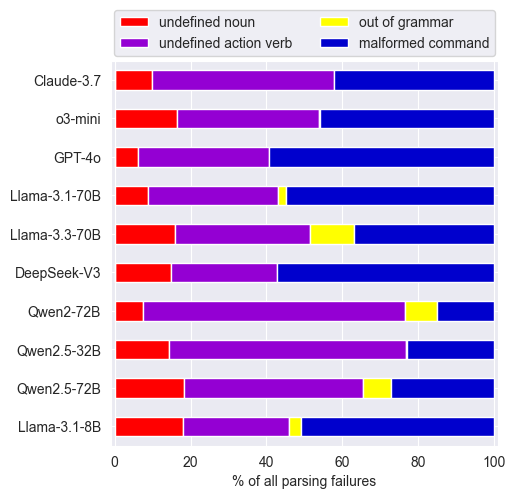

In [27]:
STACK_COLORS = ['red', 'darkviolet', 'yellow', 'mediumblue']

parse_failures = ["lark_exception", "malformed_command", "undefined_action_verb", "undefined_repr_str"]

df_aux = game_df[game_df.metric.isin(parse_failures)]
df_aux = df_aux.replace(metric_name_dict)

df_aux = df_aux[~df_aux.model.str.contains('openchat')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5C-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Llama-3-8B')]


clem_df_cull = clem_df[~clem_df.index.str.contains('openchat')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5C-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Llama-3-8B')]



df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df_cull.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2)
plt.xlabel('% of all parsing failures')
plt.xlim(-1, 101)
plt.ylabel('')

plt.savefig("results/parsing_failures_stack.pdf", format="pdf", bbox_inches="tight")

plt.show()

### Room/navigation failures
Dataframe with room/navigation failure counts/ratios:
Note: While "thing_arg1_room" and "thing_arg2_room" did not occur in the v1 results, they are implemented, and thus not omitted here.

In [28]:
room_failures_df = game_df.query('metric in ["not_room_type", "no_exit_to", "manipulating_room", "other_room_argument", "thing_arg1_room", "thing_arg2_room"]')
room_failures_df = room_failures_df.replace(metric_name_dict)
room_failures_counts = room_failures_df.groupby(['model', 'metric']).sum()
room_failures_counts = room_failures_counts.drop(columns=["game", 'experiment', 'episode'])
room_failures_counts['ratio'] = room_failures_counts / parsed_df
room_failures_counts

value     ratio
model         metric                                       
Claude-3.7    going to non-adjacent room     39.0  0.012931
              interacting with other room     0.0  0.000000
              manipulating room               0.0  0.000000
DeepSeek-V3   going to non-adjacent room    139.0  0.038946
              interacting with other room     0.0  0.000000
              manipulating room               0.0  0.000000
GPT-4o        going to non-adjacent room     78.0  0.023097
              interacting with other room     0.0  0.000000
              manipulating room               0.0  0.000000
Llama-3.1-70B going to non-adjacent room    267.0  0.046435
              interacting with other room     4.0  0.000696
              manipulating room               0.0  0.000000
Llama-3.1-8B  going to non-adjacent room    854.0  0.104248
              interacting with other room    18.0  0.002197
              manipulating room               0.0  0.000000
Llama-3.3-70B going to non-adjacent room    355.0  0.060965
              interacting with other room     6.0  0.001030
              manipulating room               0.0  0.000000
Qwen2-72B     going to non-adjacent room    586.0  0.076611
              interacting with other room    18.0  0.002353
              manipulating room               0.0  0.000000
Qwen2.5-32B   going to non-adjacent room   1162.0  0.133933
              interacting with other room     0.0  0.000000
              manipulating room               1.0  0.000115
Qwen2.5-72B   going to non-adjacent room    805.0  0.095120
              interacting with other room    27.0  0.003190
              manipulating room               1.0  0.000118
o3-mini       going to non-adjacent room     59.0  0.016033
              interacting with other room     4.0  0.001087
              manipulating room               1.0  0.000272

Overview/model comparison stacked bar plot for room/navigation failures:
Note: Non-occurring room/navigation failure types are omitted here.

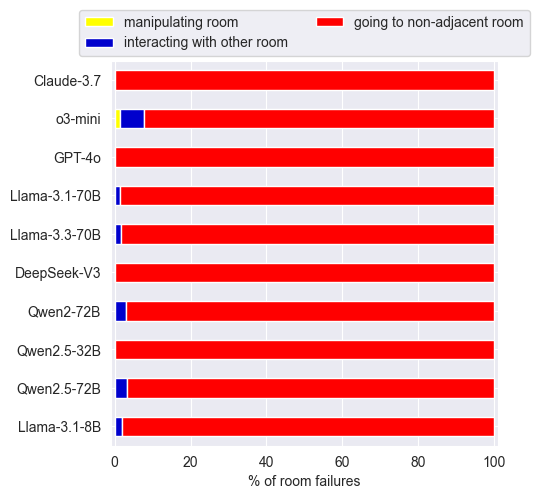

In [29]:
STACK_COLORS = ['yellow', 'darkviolet', 'red', 'mediumblue', 'yellow', 'red']

room_failures = ["not_room_type", "no_exit_to", "manipulating_room", "other_room_argument"]

df_aux = game_df[game_df.metric.isin(room_failures)]
df_aux = df_aux.replace(metric_name_dict)


df_aux = df_aux[~df_aux.model.str.contains('openchat')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5C-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Llama-3-8B')]


clem_df_cull = clem_df[~clem_df.index.str.contains('openchat')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5C-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Llama-3-8B')]


df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df_cull.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncols=2)
plt.xlabel('% of room failures')
plt.xlim(-1, 101)
plt.ylabel('')

plt.savefig("results/nav_failures_stack.pdf", format="pdf", bbox_inches="tight")

plt.show()

### Entity-related failures
Dataframe with entity-related failure counts/ratios:

In [30]:
entity_failures_df = game_df.query('metric in ["entity_not_accessible", "entity_already_inventory", "entity_state_mismatch", "entity_trait_mismatch", "inventory_limit_exceeded"]')
entity_failures_df = entity_failures_df.replace(metric_name_dict)
entity_failures_counts = entity_failures_df.groupby(['model', 'metric']).sum()
entity_failures_counts = entity_failures_counts.drop(columns=["game", 'experiment', 'episode'])
entity_failures_counts['ratio'] = entity_failures_counts / parsed_df
entity_failures_counts

value     ratio
model         metric                                       
Claude-3.7    entity already in inventory    12.0  0.003979
              entity not accessible          52.0  0.017241
              entity state mismatch         133.0  0.044098
              entity trait mismatch           1.0  0.000332
              inventory limit exceeded        3.0  0.000995
DeepSeek-V3   entity already in inventory    14.0  0.003923
              entity not accessible         125.0  0.035024
              entity state mismatch         203.0  0.056879
              entity trait mismatch           0.0  0.000000
              inventory limit exceeded        7.0  0.001961
GPT-4o        entity already in inventory    10.0  0.002961
              entity not accessible         125.0  0.037015
              entity state mismatch         190.0  0.056263
              entity trait mismatch           5.0  0.001481
              inventory limit exceeded        0.0  0.000000
Llama-3.1-70B entity already in inventory    11.0  0.001913
              entity not accessible         196.0  0.034087
              entity state mismatch         146.0  0.025391
              entity trait mismatch          11.0  0.001913
              inventory limit exceeded       18.0  0.003130
Llama-3.1-8B  entity already in inventory     8.0  0.000977
              entity not accessible        1261.0  0.153931
              entity state mismatch         288.0  0.035156
              entity trait mismatch           3.0  0.000366
              inventory limit exceeded       49.0  0.005981
Llama-3.3-70B entity already in inventory    13.0  0.002233
              entity not accessible         188.0  0.032286
              entity state mismatch         181.0  0.031084
              entity trait mismatch           4.0  0.000687
              inventory limit exceeded       20.0  0.003435
Qwen2-72B     entity already in inventory    89.0  0.011636
              entity not accessible         362.0  0.047326
              entity state mismatch         121.0  0.015819
              entity trait mismatch           0.0  0.000000
              inventory limit exceeded       11.0  0.001438
Qwen2.5-32B   entity already in inventory    14.0  0.001614
              entity not accessible         742.0  0.085523
              entity state mismatch         336.0  0.038728
              entity trait mismatch           1.0  0.000115
              inventory limit exceeded       23.0  0.002651
Qwen2.5-72B   entity already in inventory   153.0  0.018079
              entity not accessible         604.0  0.071369
              entity state mismatch         139.0  0.016424
              entity trait mismatch           5.0  0.000591
              inventory limit exceeded        9.0  0.001063
o3-mini       entity already in inventory    11.0  0.002989
              entity not accessible         197.0  0.053533
              entity state mismatch         210.0  0.057065
              entity trait mismatch           1.0  0.000272
              inventory limit exceeded        0.0  0.000000

Overview/model comparison stacked bar plot for entity-related failures:

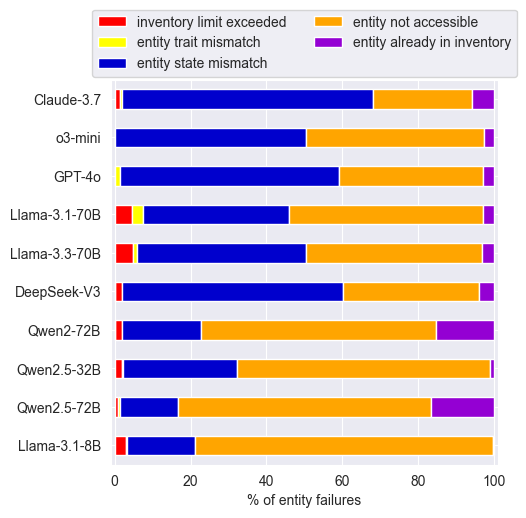

In [31]:
STACK_COLORS = ['red', 'yellow', 'khaki', 'mediumblue','orange',  'darkviolet']

entity_failures = ["entity_not_accessible", "entity_already_inventory", "entity_state_mismatch", "entity_trait_mismatch", "inventory_limit_exceeded"]

df_aux = game_df[game_df.metric.isin(entity_failures)]
df_aux = df_aux.replace(metric_name_dict)


df_aux = df_aux[~df_aux.model.str.contains('openchat')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Qwen2.5C-7B')]
df_aux = df_aux[~df_aux.model.str.contains('Llama-3-8B')]


clem_df_cull = clem_df[~clem_df.index.str.contains('openchat')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Qwen2.5C-7B')]
clem_df_cull = clem_df_cull[~clem_df_cull.index.str.contains('Llama-3-8B')]


df_aux = (df_aux.pivot(index=['game', 'model', 'experiment', 'episode'],
                       columns='metric',
                       values='value')
                .reset_index()
                .drop(columns=['game', 'experiment', 'episode'])
                .groupby('model')
                .sum()
                .sort_values(axis=1, by='metric', ascending=False))
percs = 100 * df_aux.div(df_aux.sum(axis=1), axis=0)
order = clem_df_cull.query('index not in ["LLaMA2-13B-Tiefighter"]').sort_values(by='-, clemscore').index
percs = percs.reindex(order)

percs.plot(kind='barh',
           stacked=True,
           figsize=(5, 5),
           colormap=ListedColormap(STACK_COLORS))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncols=2)
plt.xlabel('% of entity failures')
plt.xlim(-1, 101)
plt.ylabel('')

plt.savefig("results/entity_failures_stack.pdf", format="pdf", bbox_inches="tight")

plt.show()

## Overview tables
Dispersion metrics over all episodes. Note that this uses groupby, which will ignore NaN values, according to the clembench documentation!

In [32]:
stats_df = build_dispersion_table(['game', 'model', 'metric'], game_df) # could also use raw_df for results for all games
stats_df

mean        std   
game          model      metric                                          
adventuregame Claude-3.7 Aborted                   0.020833   0.143325  \
                         Lose                      0.097222   0.297294   
                         Main Score               88.194444  32.380016   
                         Parsed Request Count     20.944444   8.523745   
                         Played                    0.979167   0.143325   
...                                                     ...        ...   
              o3-mini    undefined_action          0.000000   0.000000   
                         undefined_action_verb     1.493056   3.713511   
                         undefined_argument_type   0.000000   0.000000   
                         undefined_repr_str        0.659722   1.947432   
                         world_state_discrepancy   0.000000   0.000000   

                                                          var  median    max   
game          model      metric                                                
adventuregame Claude-3.7 Aborted                     0.020542     0.0    1.0  \
                         Lose                        0.088384     0.0    1.0   
                         Main Score               1048.465423   100.0  100.0   
                         Parsed Request Count       72.654235    20.0   50.0   
                         Played                      0.020542     1.0    1.0   
...                                                       ...     ...    ...   
              o3-mini    undefined_action            0.000000     0.0    0.0   
                         undefined_action_verb      13.790161     0.0   19.0   
                         undefined_argument_type     0.000000     0.0    0.0   
                         undefined_repr_str          3.792492     0.0   19.0   
                         world_state_discrepancy     0.000000     0.0    0.0   

                                                  min      skew  
game          model      metric                                  
adventuregame Claude-3.7 Aborted                  0.0  6.780627  
                         Lose                     0.0  2.747788  
                         Main Score               0.0 -2.392364  
                         Parsed Request Count     9.0  1.204925  
                         Played                   0.0 -6.780627  
...                                               ...       ...  
              o3-mini    undefined_action         0.0  0.000000  
                         undefined_action_verb    0.0  2.790745  
                         undefined_argument_type  0.0  0.000000  
                         undefined_repr_str       0.0  6.464195  
                         world_state_discrepancy  0.0  0.000000  

[420 rows x 7 columns]

In [33]:
failure_stats_by_phase_df = stats_df.query('metric in ["action_parsing_fail", "action_resolution_fail"]')
failure_stats_by_phase_df

mean        std   
game          model         metric                                         
adventuregame Claude-3.7    action_parsing_fail      0.923611   1.770306  \
                            action_resolution_fail   1.687500   3.542882   
              DeepSeek-V3   action_parsing_fail      1.166667   2.848138   
                            action_resolution_fail   3.486111   6.378489   
              GPT-4o        action_parsing_fail      1.159722   2.912868   
                            action_resolution_fail   2.881944   4.544260   
              Llama-3.1-70B action_parsing_fail      1.583333   5.165193   
                            action_resolution_fail   2.750000   3.818585   
              Llama-3.1-8B  action_parsing_fail      3.684874   8.396143   
                            action_resolution_fail  10.491597   8.997769   
              Llama-3.3-70B action_parsing_fail      1.616667   3.257905   
                            action_resolution_fail   3.245833   3.951852   
              Qwen2-72B     action_parsing_fail      9.466667  14.328445   
                            action_resolution_fail   4.987500   5.022528   
              Qwen2.5-32B   action_parsing_fail      4.412500  11.241019   
                            action_resolution_fail   9.716667   9.747166   
              Qwen2.5-72B   action_parsing_fail      7.258333  12.547147   
                            action_resolution_fail   7.208333   6.372530   
              o3-mini       action_parsing_fail      4.034722   8.415282   
                            action_resolution_fail   3.430556   5.610496   

                                                           var  median   max   
game          model         metric                                             
adventuregame Claude-3.7    action_parsing_fail       3.133984     0.0  10.0  \
                            action_resolution_fail   12.552010     0.0  20.0   
              DeepSeek-V3   action_parsing_fail       8.111888     0.0  17.0   
                            action_resolution_fail   40.685120     1.0  41.0   
              GPT-4o        action_parsing_fail       8.484800     0.0  19.0   
                            action_resolution_fail   20.650301     1.0  30.0   
              Llama-3.1-70B action_parsing_fail      26.679219     0.0  44.0   
                            action_resolution_fail   14.581590     2.0  26.0   
              Llama-3.1-8B  action_parsing_fail      70.495213     0.0  50.0   
                            action_resolution_fail   80.959845     8.0  39.0   
              Llama-3.3-70B action_parsing_fail      10.613947     0.0  21.0   
                            action_resolution_fail   15.617137     2.0  28.0   
              Qwen2-72B     action_parsing_fail     205.304324     2.0  50.0   
                            action_resolution_fail   25.225785     3.0  33.0   
              Qwen2.5-32B   action_parsing_fail     126.360513     0.0  50.0   
                            action_resolution_fail   95.007252     6.0  49.0   
              Qwen2.5-72B   action_parsing_fail     157.430893     1.0  50.0   
                            action_resolution_fail   40.609135     6.0  35.0   
              o3-mini       action_parsing_fail      70.816968     0.0  40.0   
                            action_resolution_fail   31.477661     1.0  30.0   

                                                    min      skew  
game          model         metric                                 
adventuregame Claude-3.7    action_parsing_fail     0.0  2.395017  
                            action_resolution_fail  0.0  3.182009  
              DeepSeek-V3   action_parsing_fail     0.0  3.249075  
                            action_resolution_fail  0.0  4.104527  
              GPT-4o        action_parsing_fail     0.0  3.745877  
                            action_resolution_fail  0.0  3.225403  
              Llama-3.1-70B action_parsing_fail     0.0  5.178843  
           

Break results down by experiment:

In [34]:
detailed_stats_df = build_dispersion_table(['game', 'model', 'experiment', 'metric'], game_df) # could also use raw_df for results for all games
detailed_stats_df

mean   
game          model      experiment       metric                            
adventuregame Claude-3.7 basic-easy       Aborted                   0.000  \
                                          Lose                      0.250   
                                          Main Score               75.000   
                                          Parsed Request Count     14.625   
                                          Played                    1.000   
...                                                                   ...   
              o3-mini    new-words-medium undefined_action          0.000   
                                          undefined_action_verb     6.250   
                                          undefined_argument_type   0.000   
                                          undefined_repr_str        0.875   
                                          world_state_discrepancy   0.000   

                                                                         std   
game          model      experiment       metric                               
adventuregame Claude-3.7 basic-easy       Aborted                   0.000000  \
                                          Lose                      0.447214   
                                          Main Score               44.721360   
                                          Parsed Request Count      2.825479   
                                          Played                    0.000000   
...                                                                      ...   
              o3-mini    new-words-medium undefined_action          0.000000   
                                          undefined_action_verb     5.170429   
                                          undefined_argument_type   0.000000   
                                          undefined_repr_str        1.454877   
                                          world_state_discrepancy   0.000000   

                                                                           var   
game          model      experiment       metric                                 
adventuregame Claude-3.7 basic-easy       Aborted                     0.000000  \
                                          Lose                        0.200000   
                                          Main Score               2000.000000   
                                          Parsed Request Count        7.983333   
                                          Played                      0.000000   
...                                                                        ...   
              o3-mini    new-words-medium undefined_action            0.000000   
                                          undefined_action_verb      26.733333   
                                          undefined_argument_type     0.000000   
                                          undefined_repr_str          2.116667   
                                          world_state_discrepancy     0.000000   

                                                                   median   
game          model      experiment       metric                            
adventuregame Claude-3.7 basic-easy       Aborted                     0.0  \
                                          Lose                        0.0   
                                          Main Score                100.0   
                                          Parsed Request Count       15.0   
                                          Played                      1.0   
...                                                                   ...   
              o3-mini    new-words-medium undefined_action            0.0   
                                          undefined_action_verb       5.0   
                                          undefined_argument_type     0.0   
                                          undefined_repr_str          0.0   
                                   

In [35]:
stats_df.to_csv('results/adventuregame_stats.csv')
detailed_stats_df.to_csv('results/adventuregame_stats_detailed.csv')

In [36]:
stats_df.to_html('results/adventuregame_stats.html')
detailed_stats_df.to_html('results/adventuregame_stats_detailed.html')

Condensed tables:

In [37]:
game_df

,game,model,experiment,episode,metric,value
0,adventuregame,Claude-3.7,basic-easy,episode_0,Violated Request Count,0.0
1,adventuregame,Claude-3.7,basic-easy,episode_0,Parsed Request Count,10.0
2,adventuregame,Claude-3.7,basic-easy,episode_0,Request Count,10.0
3,adventuregame,Claude-3.7,basic-easy,episode_0,Request Success Ratio,1.0
4,adventuregame,Claude-3.7,basic-easy,episode_0,hallucination_count,0.0
...,...,...,...,...,...,...
84583,adventuregame,Qwen2.5-32B,planning-hard-preexplore,episode_5,Played,0.0
84584,adventuregame,Qwen2.5-32B,planning-hard-preexplore,episode_6,Played,0.0
84585,adventuregame,Qwen2.5-32B,planning-hard-preexplore,episode_7,Played,0.0
84586,adventuregame,Qwen2.5-32B,planning-hard-preexplore,episode_8,Played,0.0


In [38]:
selected_stats_df = game_df.drop(columns=["game"])
selected_metrics_list = ["Main Score", "Played", "Success", "action_parsing_fail", "action_resolution_fail", "successful_actions"]
selected_stats_df = selected_stats_df.query('metric in ["Main Score", "Played"]')
selected_stats_df = build_dispersion_table(['model', 'experiment', 'metric'], selected_stats_df)
selected_stats_df = selected_stats_df.drop(columns=["var", "median", "max", "min", "skew"])
selected_stats_df = selected_stats_df.rename(metric_name_dict)
selected_stats_df = selected_stats_df.rename({"Main Score": "Score"})
selected_stats_df = selected_stats_df.reset_index()
selected_stats_df = pd.pivot_table(selected_stats_df, index=['model', 'experiment'], columns='metric')
selected_stats_df

mean              std           
metric                            Played  Score    Played      Score
model      experiment                                               
Claude-3.7 basic-easy             1.0000  75.00  0.000000  44.721360
           basic-easy-invlimit    1.0000  81.25  0.000000  40.311289
           basic-easy-preexplore  1.0000  75.00  0.000000  44.721360
           basic-hard             0.9375  81.25  0.250000  40.311289
           basic-hard-invlimit    0.9375  93.75  0.250000  25.000000
...                                  ...    ...       ...        ...
o3-mini    basic-hard-invlimit    0.9375  93.75  0.250000  25.000000
           basic-hard-preexplore  0.7500  75.00  0.447214  44.721360
           new-words-easy         1.0000  87.50  0.000000  34.156503
           new-words-hard         0.9375  87.50  0.250000  34.156503
           new-words-medium       0.4375  43.75  0.512348  51.234754

[126 rows x 4 columns]

In [39]:
selected_stats_df.to_html("results/selected_stats.html")

In [40]:
selected_stats_styled = selected_stats_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(precision=2)
selected_stats_styled.to_latex("results/selected_stats.tex", clines="skip-last;data")

Limit to selected top models:

In [41]:
top_stats_df = game_df.drop(columns=["game"])
# top_stats_df = top_stats_df.query('metric in ["Main Score", "Played", "Success", "hallucination_count"]')
# top_stats_df = top_stats_df.query('metric in ["Main Score", "Played", "achieved_goal_rating"]')
# top_stats_df = top_stats_df.query('metric in ["Main Score", "Played", "achieved_goal_rating", "plan_average_viability_ratio", "hallucination_count"]')
top_stats_df = top_stats_df.query('metric in ["Main Score", "Played", "achieved_goal_rating", "hallucination_count"]')
top_stats_df = top_stats_df.query("model in ['o3-mini', 'Claude-3.7', 'Llama-3.1-70B', 'Qwen2.5-32B', 'GPT-4o', 'Llama-3.1-8B', 'Qwen2.5-72B', 'Qwen2-72B', 'Llama-3.3-70B', 'DeepSeek-V3']")

# top_stats_df = top_stats_df.query("experiment in ['basic-easy', 'basic-easy-invlimit', 'basic-easy-preexplore', 'basic-hard', 'basic-hard-invlimit', 'basic-hard-preexplore', 'new-words-easy', 'new-words-medium', 'new-words-hard']")
top_stats_df = top_stats_df.query("experiment in ['basic-easy', 'basic-hard', 'basic-easy-preexplore', 'basic-hard-preexplore', 'basic-easy-invlimit', 'basic-hard-invlimit', 'new-words-easy', 'new-words-medium', 'new-words-hard']")

top_stats_df = build_dispersion_table(['model', 'experiment', 'metric'], top_stats_df)
top_stats_df = top_stats_df.drop(columns=["var", "median", "max", "min", "skew", "std"])
top_stats_df = top_stats_df.rename(metric_name_dict)
top_stats_df = top_stats_df.rename({"Main Score": "Quality"})
top_stats_df = top_stats_df.rename({"Played": "% Played"})
# top_stats_df = top_stats_df.rename({"Success": "% Success"})
top_stats_df = top_stats_df.rename({"hallucination_count": "% Hal."})
top_stats_df = top_stats_df.rename({"achieved_goal_rating": "% Goals"})
# top_stats_df = top_stats_df.rename({"plan_average_viability_ratio": "Plan Viability"})
top_stats_df = top_stats_df.reset_index()
top_stats_df = pd.pivot_table(top_stats_df, index=['model', 'experiment'], columns='metric')
top_stats_df[('metric', 'clemscore')] = top_stats_df[('mean', '% Played')] * top_stats_df[('mean', 'Quality')]
top_stats_df[('metric', 'Quality')] = top_stats_df[('mean', 'Quality')]
top_stats_df[('metric', '% Played')] = top_stats_df[('mean', '% Played')] * 100
top_stats_df[('metric', "% Lose")] = top_stats_df[('mean', "% Hal.")] * 100
top_stats_df[('metric', 'Goal Rate')] = top_stats_df[('mean', '% Goals')]
# top_stats_df[('metric', 'Plan Viability')] = top_stats_df[('mean', 'Plan Viability')] * 100
# top_stats_df[('metric', '% Success')] = top_stats_df[('mean', '% Success')] * 100
# top_stats_df = top_stats_df.drop(columns=[("mean", '% Played'), ("mean", '% Success'), ("mean", 'Quality'), ('mean', "% Hal.")])
# top_stats_df = top_stats_df.drop(columns=[("mean", '% Played'), ("mean", 'Quality'), ('mean', '% Goals'), ('mean', 'Plan Viability'), ('mean', "% Hal.")])
top_stats_df = top_stats_df.drop(columns=[("mean", '% Played'), ("mean", 'Quality'), ('mean', '% Goals'), ('mean', "% Hal.")])
top_stats_df

metric                                   
metric                            clemscore Quality % Played % Lose  Goal Rate
model      experiment                                                         
Claude-3.7 basic-easy             75.000000   75.00   100.00  25.00  75.000000
           basic-easy-invlimit    81.250000   81.25   100.00  18.75  81.250000
           basic-easy-preexplore  75.000000   75.00   100.00  25.00  75.000000
           basic-hard             76.171875   81.25    93.75  12.50  91.666667
           basic-hard-invlimit    87.890625   93.75    93.75   0.00  95.833333
...                                     ...     ...      ...    ...        ...
o3-mini    basic-hard-invlimit    87.890625   93.75    93.75   0.00  93.750000
           basic-hard-preexplore  56.250000   75.00    75.00   0.00  83.333333
           new-words-easy         87.500000   87.50   100.00  12.50  95.833333
           new-words-hard         82.031250   87.50    93.75   6.25  91.666667
           new-words-medium       19.140625   43.75    43.75   0.00  66.666667

[90 rows x 5 columns]

In [42]:
top_stats_df.to_html("results/top_model_experiment_stats.html")

In [43]:
top_stats_df.to_csv("results/top_model_experiment_stats.csv")

In [44]:
top_stats_styled = top_stats_df.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(precision=1)
top_stats_styled.to_latex("results/top_model_experiment_stats.tex", clines="skip-last;data")

Hallucinations:

In [45]:
hallucination_df = game_df[game_df.metric == 'hallucination_count']
hallucination_df

,game,model,experiment,episode,metric,value
4,adventuregame,Claude-3.7,basic-easy,episode_0,hallucination_count,0.0
45,adventuregame,Claude-3.7,basic-easy,episode_1,hallucination_count,0.0
86,adventuregame,Claude-3.7,basic-easy,episode_10,hallucination_count,0.0
127,adventuregame,Claude-3.7,basic-easy,episode_11,hallucination_count,0.0
168,adventuregame,Claude-3.7,basic-easy,episode_12,hallucination_count,1.0
...,...,...,...,...,...,...
82373,adventuregame,Qwen2.5-32B,planning-hard-preexplore,episode_5,hallucination_count,0.0
82414,adventuregame,Qwen2.5-32B,planning-hard-preexplore,episode_6,hallucination_count,0.0
82455,adventuregame,Qwen2.5-32B,planning-hard-preexplore,episode_7,hallucination_count,0.0
82496,adventuregame,Qwen2.5-32B,planning-hard-preexplore,episode_8,hallucination_count,0.0


In [46]:
llama3_1_70b_hallu = hallucination_df.query('model == "Llama-3.1-70b-Instruct" and value == 1')
llama3_1_70b_hallu

,game,model,experiment,episode,metric,value


In [47]:
openchat_hallu = hallucination_df.query('model == "openchat3.5" and value == 1')
openchat_hallu

,game,model,experiment,episode,metric,value


In [48]:
hallucination_counts = hallucination_df.groupby(['model']).sum()
hallucination_sums = hallucination_counts.iloc[0:19, [4]]
# hallucination_sums['Ratio'] = hallucination_sums.value / 64
hallucination_sums['Percentage'] = (hallucination_sums.value / 128) * 100
hallucination_sums = hallucination_sums.rename(columns = {"value": "Total"})
hallucination_sums

,Total,Percentage
model,,
Claude-3.7,14.0,10.93750
DeepSeek-V3,57.0,44.53125
GPT-4o,54.0,42.18750
Llama-3.1-70B,96.0,75.00000
Llama-3.1-8B,48.0,37.50000
Llama-3.3-70B,119.0,92.96875
Qwen2-72B,78.0,60.93750
Qwen2.5-32B,56.0,43.75000
Qwen2.5-72B,82.0,64.06250


In [49]:
hallucination_sums.to_html('results/hallucination_sums.html')

In [50]:
h_styled = hallucination_sums.style.set_table_styles([
    {'selector': 'toprule', 'props': ':hline;'},
    {'selector': 'bottomrule', 'props': ':hline;'},
], overwrite=False).format(subset="Percentage", precision=3).format(subset="Total", precision=0)
h_styled.to_latex('results/hallucination_sums.tex')

In [51]:
h_styled = hallucination_sums.style.format(subset="Percentage", precision=1).format(subset="Total", precision=0).to_latex('results/hallucination_sums.tex', clines="skip-last;data")

In [52]:
detailed_hallucination_df = build_dispersion_table(['model'], hallucination_df)
detailed_hallucination_df

,mean,std,var,median,max,min,skew
model,,,,,,,
Claude-3.7,0.097222,0.297294,0.088384,0.0,1.0,0.0,2.747788
DeepSeek-V3,0.395833,0.490736,0.240822,0.0,1.0,0.0,0.430512
GPT-4o,0.375000,0.485813,0.236014,0.0,1.0,0.0,0.521850
Llama-3.1-70B,0.400000,0.490922,0.241004,0.0,1.0,0.0,0.410820
Llama-3.1-8B,0.201681,0.402101,0.161685,0.0,1.0,0.0,1.496379
Llama-3.3-70B,0.495833,0.501028,0.251029,0.0,1.0,0.0,0.016772
Qwen2-72B,0.325000,0.469354,0.220293,0.0,1.0,0.0,0.751973
Qwen2.5-32B,0.233333,0.423836,0.179637,0.0,1.0,0.0,1.268921
Qwen2.5-72B,0.341667,0.475260,0.225872,0.0,1.0,0.0,0.671902


## Specific metrics plots
Bar plot overview by model and experiment:

In [53]:
def metric_bar_plot(source_df, metric, max_value=1):
    metric_df = source_df[game_df.metric == metric].sort_values('experiment')
    fig, ax = plt.subplots(figsize=(14, 4))

    g = sns.barplot(metric_df,
                x='experiment',
                y='value',
                hue='model', 
                ax=ax)

    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
    plt.ylim(0, max_value)
    plt.ylabel(metric)

    plt.show()

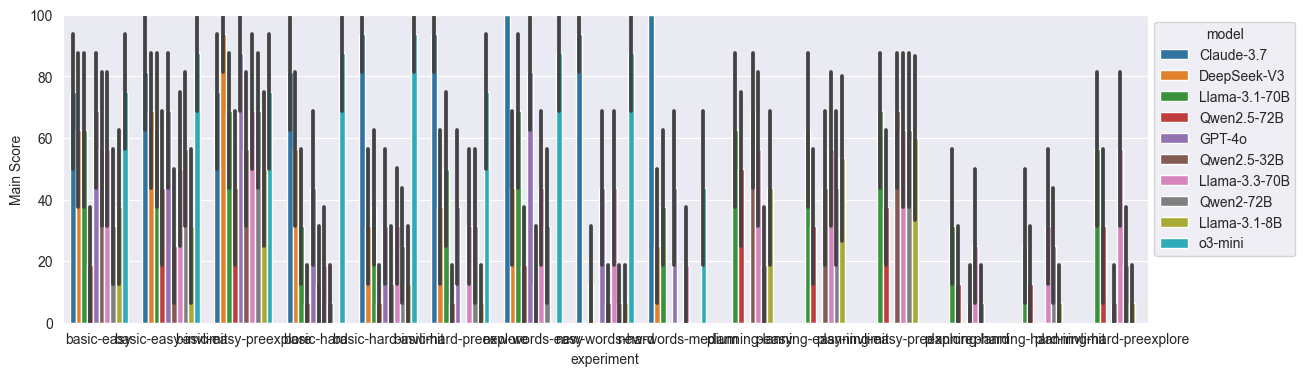

In [54]:
metric_bar_plot(game_df, "Main Score", max_value=100)

# Aborted episodes stacked bars

In [55]:
abort_metrics_turn = ["command_tag_missing", "next_actions_missing", "hallucination"]
abort_metrics_ep = ["turn_limit_loss"]

In [56]:
def get_episode_abort_metrics(model_id: str, variant: str, episode: str):
    abort_dict = {"turn_limit": 0, "command_tag_missing": 0, "next_actions_missing": 0, "hallucination": 0}
    # load episode scores from JSON:
    with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
        scores = json.load(scores_file)
    # check episode scores:
    ep_scores = scores['episode scores']
    if ep_scores["Aborted"] == 1:
        abort_dict["turn_limit"] = ep_scores["turn_limit_loss"]
    # check turn scores:
    turns_scores = scores['turn scores']
    for turn_scores in turns_scores.values():
        if turn_scores["command_tag_missing"] == 1:
            abort_dict["command_tag_missing"] = turn_scores["command_tag_missing"]
            if turn_scores["hallucination"] == 1:
                abort_dict["hallucination"] = turn_scores["hallucination"]
            break
        if turn_scores["next_actions_missing"] == 1:
            abort_dict["next_actions_missing"] = turn_scores["next_actions_missing"]
            break

    return abort_dict

In [57]:
# model_id = "o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0"
# variant = "1_home_deliver_three_planning_easy"
# episode = "episode_3"
# episode = "episode_9"
# get_episode_abort_metrics(model_id, variant, episode)

In [58]:
def get_abort_metrics(model_id: str, variants: list):
    episodes = [f"episode_{number}" for number in range(0,16)]
    overall_abort_dict = {"turn_limit": 0, "command_tag_missing": 0, "next_actions_missing": 0, "hallucination": 0}
    for variant in variants:
        for episode in episodes:
            cur_abort_dict = get_episode_abort_metrics(model_id, variant, episode)
            for key, val in cur_abort_dict.items():
                # print(key, val)
                overall_abort_dict[key] += val

    return overall_abort_dict

In [59]:
variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

# get_abort_metrics("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants)

In [60]:
def get_model_set_abort_metrics(model_ids: list, variants: list):
    abort_totals = dict()
    for model_id in model_ids:
        overall_abort_dict = get_abort_metrics(model_id, variants)
        abort_totals[model_name_dict[model_id]] = overall_abort_dict

    return abort_totals

In [61]:
all_models_all_abort = get_model_set_abort_metrics(final_models, variants)
all_models_all_abort

{'Llama-3.1-70B': {'turn_limit': 16,
  'command_tag_missing': 0,
  'next_actions_missing': 0,
  'hallucination': 0},
 'Llama-3.3-70B': {'turn_limit': 11,
  'command_tag_missing': 1,
  'next_actions_missing': 0,
  'hallucination': 0},
 'Qwen2.5-32B': {'turn_limit': 71,
  'command_tag_missing': 0,
  'next_actions_missing': 0,
  'hallucination': 0},
 'Qwen2-72B': {'turn_limit': 53,
  'command_tag_missing': 2,
  'next_actions_missing': 0,
  'hallucination': 0},
 'Qwen2.5-72B': {'turn_limit': 69,
  'command_tag_missing': 0,
  'next_actions_missing': 0,
  'hallucination': 0},
 'Llama-3.1-8B': {'turn_limit': 58,
  'command_tag_missing': 1,
  'next_actions_missing': 0,
  'hallucination': 0}}

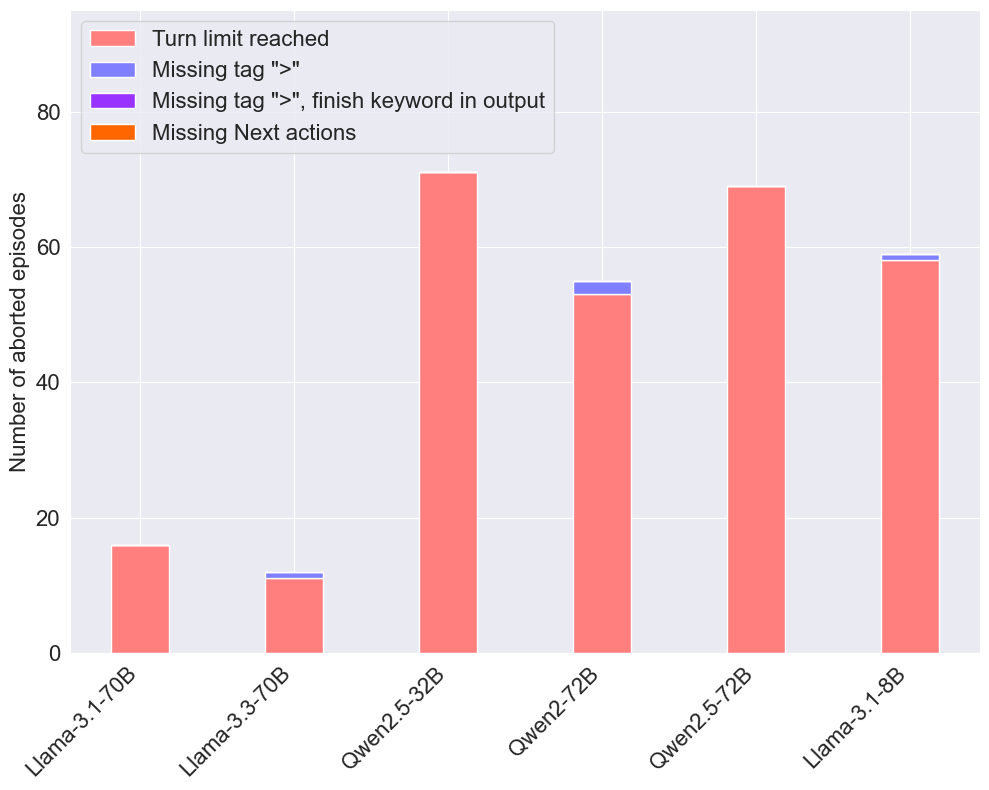

In [62]:
abort_metrics_turn = ["command_tag_missing", "next_actions_missing", "hallucination"]
abort_metrics_ep = ["turn_limit_loss"]

# Prepare data for plotting
models = list()

turn_limit_losses = list()
command_tag_missings = list()
next_actions_missings = list()
hallucinations = list()

# opponent_faster_losses = []

for model_name, abort_data in all_models_all_abort.items():
    # Create shorter model name for display
    # short_name = model_name.split('-t0.0--')[0].split('-2024')[0].split('-2025')[0].replace('-Instruct', '').replace('-flash-exp', '').replace('-sonnet', '')
    models.append(model_name)

    # Get abort counts, default to 0 if not present
    turn_limit_losses.append(abort_data.get('turn_limit', 0))
    command_tag_missings.append(abort_data.get('command_tag_missing', 0))
    next_actions_missings.append(abort_data.get('next_actions_missing', 0))
    hallucinations.append(abort_data.get('hallucination', 0))

# print(models)

turn_limit_losses = np.array(turn_limit_losses)
command_tag_missings = np.array(command_tag_missings)
next_actions_missings = np.array(next_actions_missings)
hallucinations = np.array(hallucinations)

hallu_sub_tag_missings = command_tag_missings - hallucinations

# Set up the plot
plt.figure(figsize=(10, 8))

# Set the width of each bar and positions of the bars
width = 0.3
x = np.arange(len(models)) * 0.8  # Reduce spacing between bars

plt.ylim([0,95])

# Create the stacked bars
plt.bar(x, turn_limit_losses, width, label='Turn limit reached', color='#ff7f7f')
plt.bar(x, hallu_sub_tag_missings, width, bottom=turn_limit_losses, label='Missing tag ">"', color='#7f7fff')
plt.bar(x, hallucinations, width, bottom=hallu_sub_tag_missings + turn_limit_losses, label='Missing tag ">", finish keyword in output', color='#9933FF')
plt.bar(x, next_actions_missings, width, bottom=hallu_sub_tag_missings + turn_limit_losses + hallucinations, label='Missing Next actions', color='#FF6600')

# Customize the plot
plt.ylabel('Number of aborted episodes', fontsize=16)
# plt.title('Abort Distribution by Model', fontsize=16)
plt.xticks(x, models, rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16, loc='upper left')
# plt.grid(True, linestyle='--', alpha=0.7, axis='y')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the plot
plt.savefig('results/aborts_distribution.pdf', dpi=300, bbox_inches='tight')

# plt.close()
plt.show()

## Exploration

In [63]:
# get single episode for exploration line plot
model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
variant = "0_home_deliver_three_basic_easy"
episode = "episode_0"
with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
    scores = json.load(scores_file)
turn_scores = scores['turn scores']
turns_known_entities_ratio = [score_values['known_entities_ratio'] for score_values in turn_scores.values()]
turns_known_entities_ratio

[0.13793103448275862,
 0.13793103448275862,
 0.13793103448275862,
 0.1724137931034483,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552]

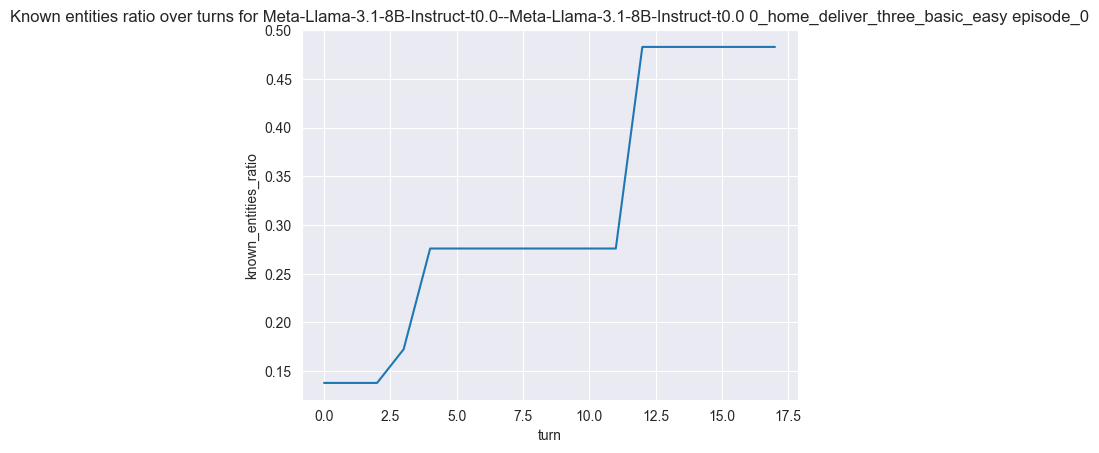

In [64]:
fig, ax = plt.subplots()
ax.plot(turns_known_entities_ratio)

ax.set(xlabel='turn', ylabel='known_entities_ratio',
       title=f'Known entities ratio over turns for {model_id} {variant} {episode}')
# ax.grid()

# fig.savefig("test.png")
plt.show()

In [65]:
# get single episode for exploration line plot
model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
# variant = "1_home_deliver_three_planning_easy"
variant = "0_home_deliver_three_basic_easy"
episode = "episode_0"
with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
    scores = json.load(scores_file)
turn_scores = scores['turn scores']
# turns_plan_command_success_ratio = [score_values['plan_command_success_ratio'] for score_values in turn_scores.values()]
turns_known_entities_ratio = [score_values['known_entities_ratio'] for score_values in turn_scores.values()]
turns_known_goal_entities_ratio = [score_values['known_goal_entities_ratio'] for score_values in turn_scores.values()]
# turns_plan_command_success_ratio

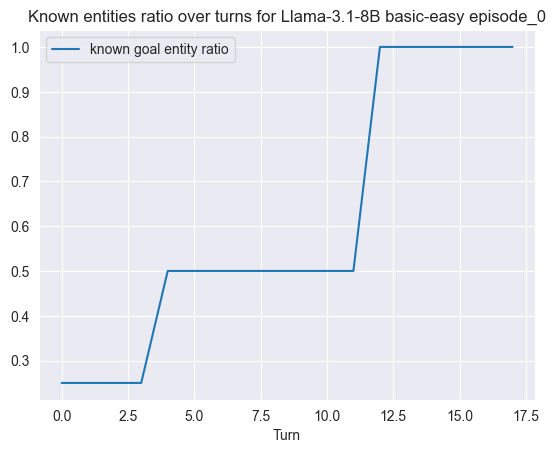

In [66]:
fig, ax = plt.subplots()

# ax.plot(turns_known_entities_ratio)
ax.plot(turns_known_goal_entities_ratio)
 #ax.plot(turns_plan_command_success_ratio)

ax.set(xlabel='Turn',
       title=f'Known entities ratio over turns for {model_name_dict[model_id]} {experiment_short_name_dict[variant]} {episode}')
# ax.grid()
ax.legend(['known goal entity ratio', 'plan viability'], loc='upper left')

# fig.savefig("test.png")
plt.show()

In [67]:
def get_score_progress_list(model_id: str, variant: str, episode: str, score: str):
    with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
        scores = json.load(scores_file)
    turn_scores = scores['turn scores']
    turns_score = [score_values[score] for score_values in turn_scores.values()]
    return turns_score

In [68]:
model_id = "Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0"
variant = "0_home_deliver_three_basic_easy"
episodes = [f"episode_{number}" for number in range(0,16)]

def get_exploration_progress_list(model_id: str, variant: str, episode: str, exploration_score: str):
    with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
        scores = json.load(scores_file)
    turn_scores = scores['turn scores']
    turns_exploration_score = [score_values[exploration_score] for score_values in turn_scores.values()]
    return turns_exploration_score

get_exploration_progress_list(model_id, variant, episodes[0], "known_entities_ratio")

[0.13793103448275862,
 0.13793103448275862,
 0.13793103448275862,
 0.1724137931034483,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.27586206896551724,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552,
 0.4827586206896552]

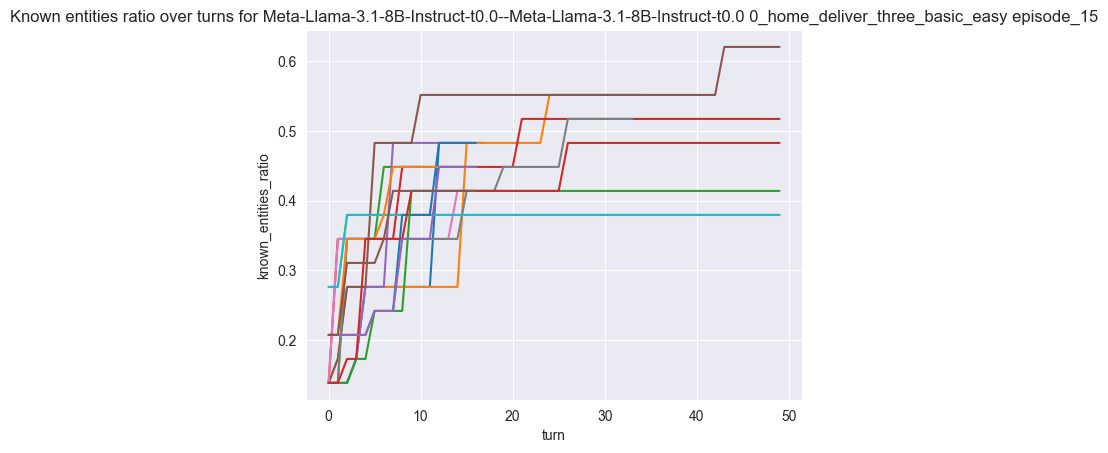

In [69]:
fig, ax = plt.subplots()

for episode in episodes:
    turns_known_entities_ratio = get_exploration_progress_list(model_id, variant, episode, "known_entities_ratio")
    ax.plot(turns_known_entities_ratio)

ax.set(xlabel='turn', ylabel='known_entities_ratio',
       title=f'Known entities ratio over turns for {model_id} {variant} {episode}')
# ax.grid()

# fig.savefig("test.png")
plt.show()

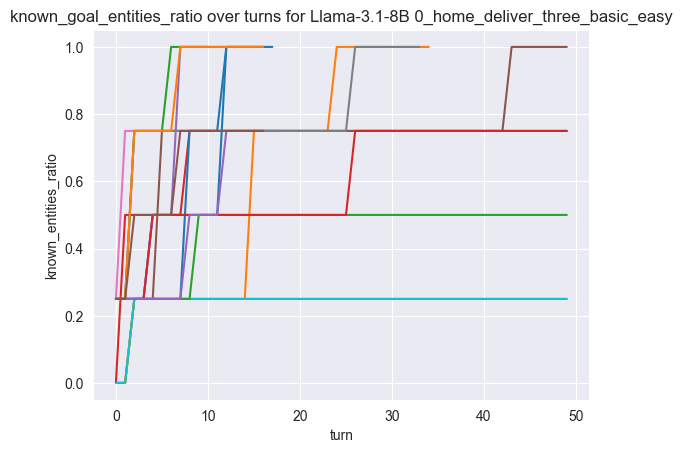

In [70]:
exploration_score = "known_goal_entities_ratio"

fig, ax = plt.subplots()

for episode in episodes:
    turns_known_entities_ratio = get_exploration_progress_list(model_id, variant, episode, exploration_score)
    ax.plot(turns_known_entities_ratio)

ax.set(xlabel='turn', ylabel='known_entities_ratio',
       title=f'{exploration_score} over turns for {model_name_dict[model_id]} {variant}')
# ax.grid()

# fig.savefig("test.png")
plt.show()

In [71]:
def get_exploration_progress_list(model_id: str, variant: str, episode: str, exploration_score: str):
    with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
        scores = json.load(scores_file)
    turn_scores = scores['turn scores']
    turns_exploration_score = [score_values[exploration_score] for score_values in turn_scores.values()]
    return turns_exploration_score

## Over all turns

In [72]:
def get_score_progress_list(model_id: str, variant: str, episode: str, score: str):
    with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
        scores = json.load(scores_file)
    turn_scores = scores['turn scores']
    turns_score = list()
    for turn_idx, turn_scores_value in enumerate(turn_scores.values()):
        if score in turn_scores_value:
            turns_score.append(turn_scores_value[score])
        else:
            print(f"{score} not in turn {turn_idx} of {model_id} {variant} {episode}")
            turns_score.append(np.nan)

    return turns_score

In [73]:
# get_score_progress_list("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", "1_home_deliver_three_planning_easy", "episode_3", "known_entities_ratio")

In [74]:
def get_avg_turns_score(model_id: str, variants: list, score: str):
    episodes = [f"episode_{number}" for number in range(0,16)]
    list_of_arrays = list()
    for variant in variants:
        for episode in episodes:
            score_progress_list = get_score_progress_list(model_id, variant, episode, score)
            prog_array = np.full(50, np.nan)
            for idx, val in enumerate(score_progress_list):
                prog_array[idx] = val
            list_of_arrays.append(prog_array)

    progress_array = np.array(list_of_arrays)
    averages_array = np.nanmean(progress_array, axis=0)

    return averages_array

In [75]:
def get_avg_last_turns_score(model_id: str, variants: list, score: str, n_turns: int):
    episodes = [f"episode_{number}" for number in range(0,16)]
    list_of_progress_lists = list()
    ep_count = 0
    for variant in variants:
        for episode in episodes:
            plan_viability_progress_list = get_score_progress_list(model_id, variant, episode, score)
            if len(plan_viability_progress_list) >= n_turns:
                list_of_progress_lists.append(plan_viability_progress_list)
                ep_count += 1
    print(f"{ep_count} viable episodes for {model_id}")
    last_n = [ep_list[-n_turns:] for ep_list in list_of_progress_lists]
    avg_last_n = list()
    for turn_idx in range(n_turns):
        turn_sum = sum([turn[turn_idx] for turn in last_n])
        avg_last_n.append(turn_sum / ep_count)

    return avg_last_n

## Epistemic/Pragmatic

In [76]:
# variants = ["1_home_deliver_three_planning_easy", "3_home_deliver_three_planning_easy_invlimittwo",
#           "5_home_deliver_three_planning_hard", "7_home_deliver_three_planning_hard_invlimittwo"]

# variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
#            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
#            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

# variants = ["1_home_deliver_three_planning_easy"]

# variants = ["0_home_deliver_three_basic_easy"]

variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]


# get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "known_entities_ratio")

known_entities_ratio not in turn 21 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 6_home_deliver_three_basic_hard episode_5
known_entities_ratio not in turn 22 of Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0 14_new-words_created_basic_hard episode_2


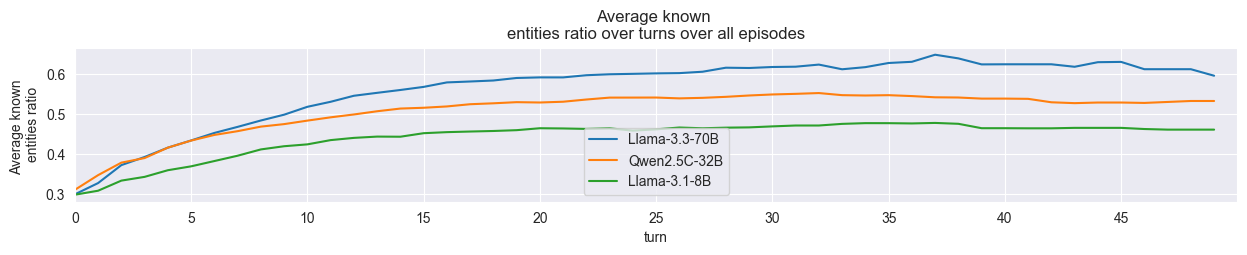

In [77]:
variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

fig, ax = plt.subplots(figsize=(15, 2))

# ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "known_entities_ratio"), label="o3-mini")
# ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, "known_entities_ratio"), label="Claude3.5")
ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, "known_entities_ratio"), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, "known_entities_ratio"), label="Qwen2.5C-32B")
ax.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, "known_entities_ratio"), label="Llama-3.1-8B")

metric_name = "known \nentities ratio"

ax.set(xlabel='turn', ylabel=f'Average {metric_name}',
       title=f'Average {metric_name} over turns over all episodes')
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

# plt.ylim([0,0.3])
# plt.yticks(np.arange(0, 0.25, step=0.2))


# plt.legend(bbox_to_anchor=(0.83, 1.1), loc="upper right")
# plt.legend()
plt.legend(loc="lower center")

fig.savefig("results/top_models_known_entities_ratio_all.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/top_models_known_entities_ratio_all.png")

plt.show()

known_goal_entities_ratio not in turn 21 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 6_home_deliver_three_basic_hard episode_5
known_goal_entities_ratio not in turn 22 of Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0 14_new-words_created_basic_hard episode_2


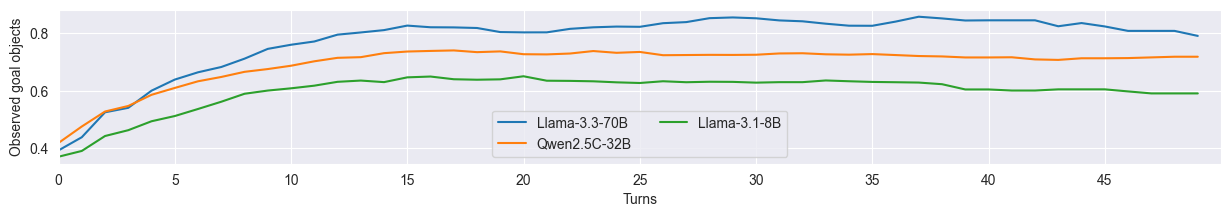

In [78]:
variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

fig, ax = plt.subplots(figsize=(15, 2))

metric = "known_goal_entities_ratio"

# ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
# ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")
ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")

metric_name = "Observed goal objects"

ax.set(xlabel='Turns', ylabel=f'{metric_name}',
       # title=f'Average {metric_name} over turns over all episodes'
       )
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

plt.legend(ncols=2, loc='lower center')

fig.savefig("results/known_goal_entities_ratio.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/known_goal_entities_ratio.png")

plt.show()

visited_rooms_ratio not in turn 21 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 6_home_deliver_three_basic_hard episode_5
visited_rooms_ratio not in turn 22 of Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0 14_new-words_created_basic_hard episode_2


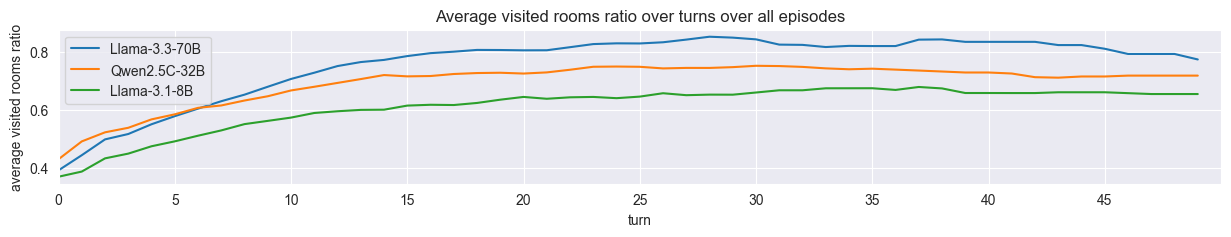

In [79]:
variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

fig, ax = plt.subplots(figsize=(15, 2))

metric = "visited_rooms_ratio"

# ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
# ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")
ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")

metric_name = "visited rooms ratio"

ax.set(xlabel='turn', ylabel=f'average {metric_name}',
       title=f'Average {metric_name} over turns over all episodes')
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

plt.legend()

fig.savefig("results/top_models_visited_rooms_ratio_all.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/top_models_visited_rooms_ratio_all.png")

plt.show()

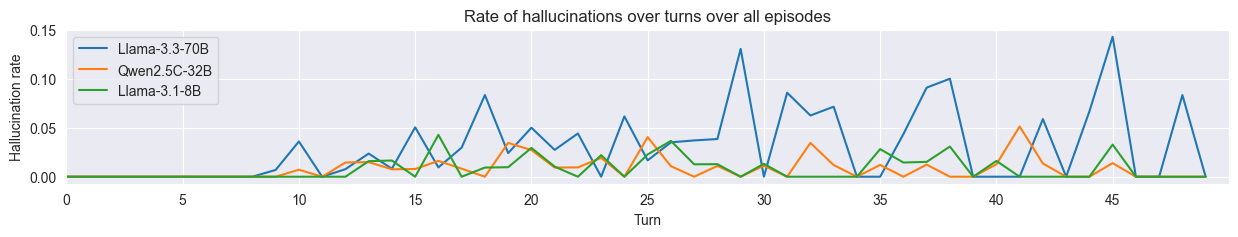

In [80]:
variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

fig, ax = plt.subplots(figsize=(15, 2))

metric = "hallucination"

# ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
# ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")
ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")

metric_name = "hallucinations"

ax.set(xlabel='Turn', ylabel=f'Hallucination rate',
       title=f'Rate of {metric_name} over turns over all episodes')
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

plt.legend()

fig.savefig("results/top_models_hallucinations_all.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/top_models_hallucinations_all.png")

plt.show()

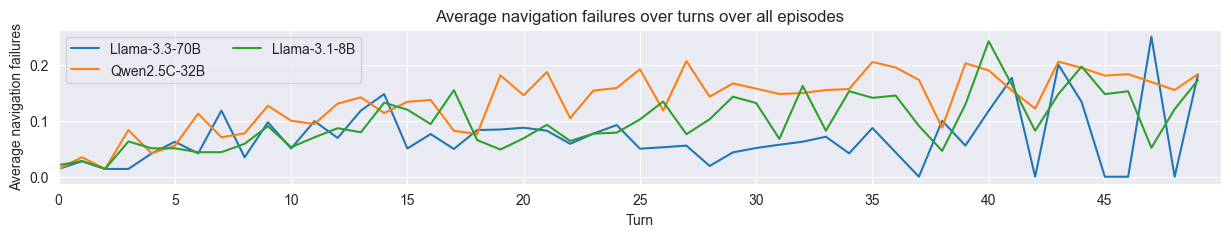

In [81]:
variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

fig, ax = plt.subplots(figsize=(15, 2))

metric = "no_exit_to"

# ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
# ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")
ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")

metric_name = "navigation failures"

ax.set(xlabel='Turn', ylabel=f'Average {metric_name}',
       title=f'Average {metric_name} over turns over all episodes')
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

plt.legend(ncols=2)

fig.savefig("results/top_models_nav_fail_all.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/top_models_nav_fail_all.png")

plt.show()

In [82]:
def get_min_turns_score(model_id: str, variants: list, score: str):
    episodes = [f"episode_{number}" for number in range(0,16)]
    list_of_arrays = list()
    for variant in variants:
        for episode in episodes:
            score_progress_list = get_score_progress_list(model_id, variant, episode, score)
            prog_array = np.full(50, np.nan)
            for idx, val in enumerate(score_progress_list):
                prog_array[idx] = val
            list_of_arrays.append(prog_array)

    progress_array = np.array(list_of_arrays)
    min_array = np.nanmin(progress_array, axis=0)

    return min_array

In [83]:
def get_median_turns_score(model_id: str, variants: list, score: str):
    episodes = [f"episode_{number}" for number in range(0,16)]
    list_of_arrays = list()
    for variant in variants:
        for episode in episodes:
            score_progress_list = get_score_progress_list(model_id, variant, episode, score)
            prog_array = np.full(50, np.nan)
            for idx, val in enumerate(score_progress_list):
                prog_array[idx] = val
            list_of_arrays.append(prog_array)

    progress_array = np.array(list_of_arrays)
    median_array = np.nanmedian(progress_array, axis=0)

    return median_array

In [84]:
def get_max_turns_score(model_id: str, variants: list, score: str):
    episodes = [f"episode_{number}" for number in range(0, 16)]
    list_of_arrays = list()
    for variant in variants:
        for episode in episodes:
            score_progress_list = get_score_progress_list(model_id, variant, episode, score)
            prog_array = np.full(50, np.nan)
            for idx, val in enumerate(score_progress_list):
                prog_array[idx] = val
            list_of_arrays.append(prog_array)

    progress_array = np.array(list_of_arrays)
    max_array = np.nanmax(progress_array, axis=0)

    return max_array

In [85]:
variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

# get_min_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "no_exit_to")

In [86]:
# get_median_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "no_exit_to")

In [87]:
# get_max_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "no_exit_to")

### Accumulative

In [88]:
def get_score_progress_list_acc(model_id: str, variant: str, episode: str, score: str):
    with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
        scores = json.load(scores_file)
    turn_scores = scores['turn scores']
    turns_score = list()
    for turn_idx, turn_scores_value in enumerate(turn_scores.values()):
        if score in turn_scores_value:
            if turn_idx == 0:
                turns_score.append(turn_scores_value[score])
            else:
                turns_score.append(turns_score[turn_idx-1] + turn_scores_value[score])
        else:
            print(f"{score} not in turn {turn_idx} of {model_id} {variant} {episode}")
            turns_score.append(np.nan)

    return turns_score

In [89]:
def get_avg_turns_score_acc(model_id: str, variants: list, score: str):
    episodes = [f"episode_{number}" for number in range(0,16)]
    list_of_arrays = list()
    for variant in variants:
        for episode in episodes:
            score_progress_list = get_score_progress_list_acc(model_id, variant, episode, score)
            prog_array = np.full(50, np.nan)
            for idx, val in enumerate(score_progress_list):
                prog_array[idx] = val
            list_of_arrays.append(prog_array)
    progress_array = np.array(list_of_arrays)
    averages_array = np.nanmean(progress_array, axis=0)

    return averages_array

In [90]:
# get_score_progress_list("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", "1_home_deliver_three_planning_easy", "episode_0", "epistemic_action")

In [91]:
# get_score_progress_list_acc("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", "1_home_deliver_three_planning_easy", "episode_0", "epistemic_action")

In [92]:
# variants = ["1_home_deliver_three_planning_easy", "3_home_deliver_three_planning_easy_invlimittwo",
#           "5_home_deliver_three_planning_hard", "7_home_deliver_three_planning_hard_invlimittwo"]

# variants = ["0_home_deliver_three_basic_easy", "1_home_deliver_three_planning_easy", "2_home_deliver_three_basic_easy_invlimittwo",
#            "3_home_deliver_three_planning_easy_invlimittwo", "4_home_deliver_three_basic_hard", "5_home_deliver_three_planning_hard",
#            "6_home_deliver_three_basic_hard_invlimittwo", "7_home_deliver_three_planning_hard_invlimittwo"]

# variants = ["1_home_deliver_three_planning_easy"]

variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

# variants = ["0_home_deliver_three_basic_easy"]

# get_avg_turns_score_acc("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "epistemic_action")

epistemic_action not in turn 21 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 6_home_deliver_three_basic_hard episode_5
epistemic_action not in turn 22 of Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0 14_new-words_created_basic_hard episode_2


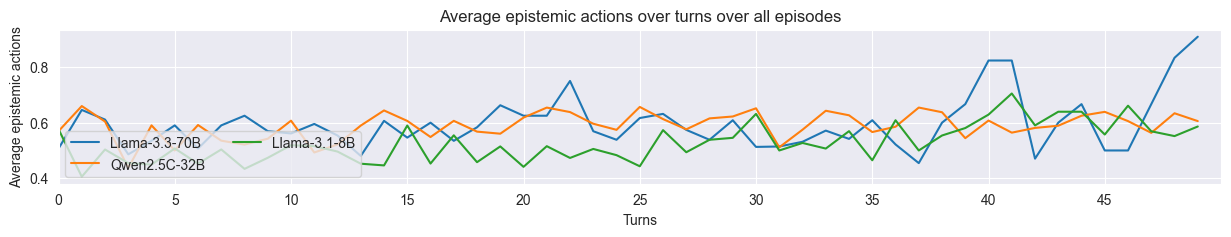

In [93]:
variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

fig, ax = plt.subplots(figsize=(15, 2))

metric = "epistemic_action"

# ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
# ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")
ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")

metric_name = "epistemic actions"

ax.set(xlabel='Turns', ylabel=f'Average {metric_name}',
       title=f'Average {metric_name} over turns over all episodes')
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

# plt.legend()
plt.legend(loc="lower left", ncols=2)

fig.savefig("results/top_models_epistemic_actions_all.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/top_models_epistemic_actions_all.png")

plt.show()

epistemic_action not in turn 21 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 6_home_deliver_three_basic_hard episode_5
epistemic_action not in turn 22 of Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0 14_new-words_created_basic_hard episode_2


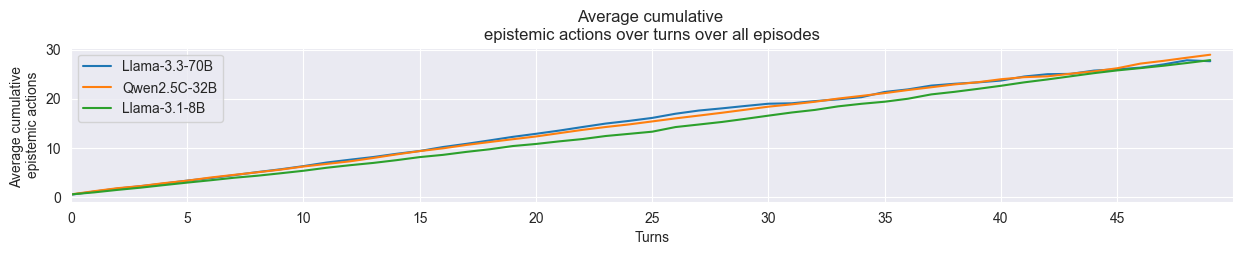

In [94]:
variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

fig, ax = plt.subplots(figsize=(15, 2))

metric = "epistemic_action"

# ax.plot(get_avg_turns_score_acc("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
# ax.plot(get_avg_turns_score_acc("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")
ax.plot(get_avg_turns_score_acc("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score_acc("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax.plot(get_avg_turns_score_acc("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")

metric_name = "cumulative \nepistemic actions"

ax.set(xlabel='Turns', ylabel=f'Average {metric_name}',
       title=f'Average {metric_name} over turns over all episodes')
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

plt.legend()

fig.savefig("results/top_models_cumulative_epistemic_actions_all.pdf", format="pdf", bbox_inches="tight")
fig.savefig("results/top_models_cumulative_epistemic_actions_all.png")

plt.show()

effective_epistemic_gain_amount not in turn 21 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 6_home_deliver_three_basic_hard episode_5
effective_epistemic_gain_amount not in turn 22 of Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0 14_new-words_created_basic_hard episode_2


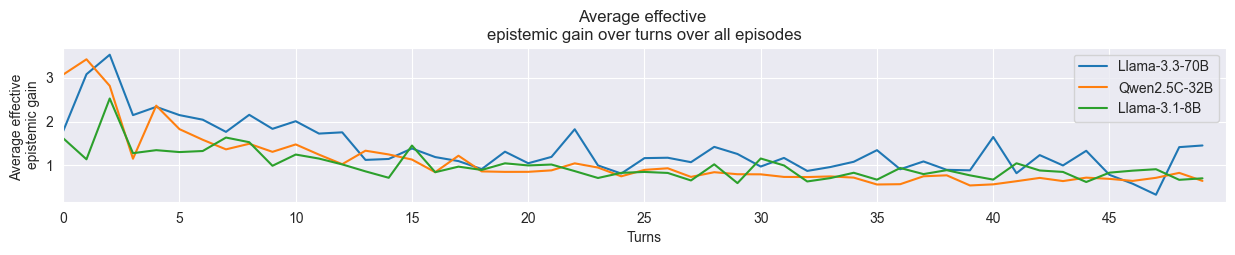

In [95]:
variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

fig, ax = plt.subplots(figsize=(15, 2))

metric = "effective_epistemic_gain_amount"

# ax.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
# ax.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")
ax.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")

metric_name = "effective \nepistemic gain"

ax.set(xlabel='Turns', ylabel=f'Average {metric_name}',
       title=f'Average {metric_name} over turns over all episodes')
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

plt.legend()

plot_tag = "epistemic_gain"
fig.savefig(f"results/top_models_{plot_tag}_all.pdf", format="pdf", bbox_inches="tight")
fig.savefig(f"results/top_models_{plot_tag}_all.png")

plt.show()

effective_epistemic_gain_amount not in turn 21 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 6_home_deliver_three_basic_hard episode_5
effective_epistemic_gain_amount not in turn 22 of Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0 14_new-words_created_basic_hard episode_2


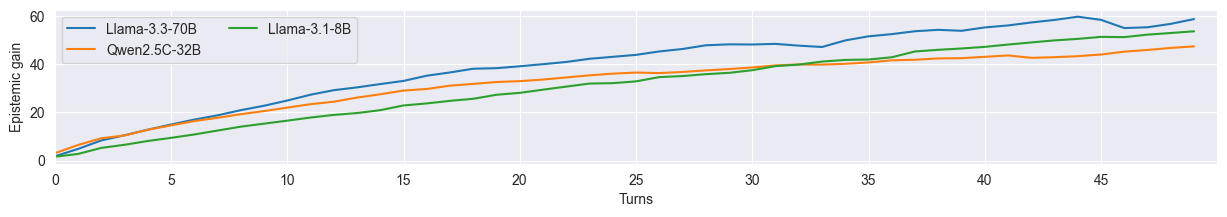

In [96]:
variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

fig, ax = plt.subplots(figsize=(15, 2))

metric = "effective_epistemic_gain_amount"

# ax.plot(get_avg_turns_score_acc("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
# ax.plot(get_avg_turns_score_acc("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")
ax.plot(get_avg_turns_score_acc("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
ax.plot(get_avg_turns_score_acc("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax.plot(get_avg_turns_score_acc("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")

metric_name = "Epistemic gain"

ax.set(xlabel='Turns', ylabel=f'{metric_name}',
       # title=f'Average {metric_name} over turns over all episodes'
       )
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

plt.legend(ncols=2)

plot_tag = "cumulative_epistemic_gain"
fig.savefig(f"results/{plot_tag}.pdf", format="pdf", bbox_inches="tight")
fig.savefig(f"results/{plot_tag}.png")

plt.show()

#### Paired epistemic gain and known goal entities plots

In [97]:
# plart =

known_goal_entities_ratio not in turn 22 of Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0 14_new-words_created_basic_hard episode_2
known_goal_entities_ratio not in turn 21 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 6_home_deliver_three_basic_hard episode_5
effective_epistemic_gain_amount not in turn 22 of Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0 14_new-words_created_basic_hard episode_2
effective_epistemic_gain_amount not in turn 21 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 6_home_deliver_three_basic_hard episode_5


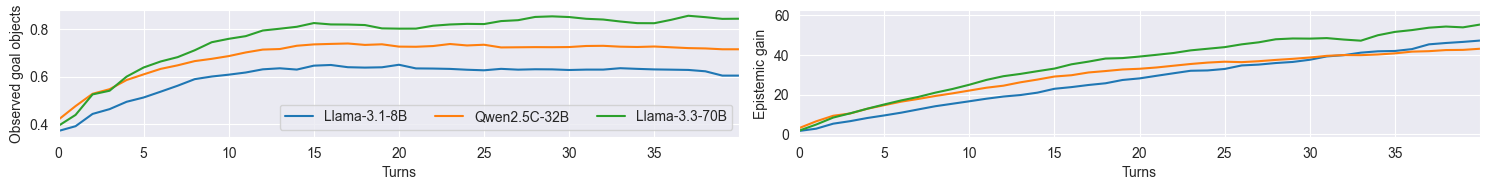

In [98]:
variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 2))



metric = "known_goal_entities_ratio"

ax1.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")
ax1.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax1.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
# ax1.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
# ax1.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")

metric_name = "Observed goal objects"

ax1.set(xlabel='Turns', ylabel=f'{metric_name}',
       # title=f'Average {metric_name} over turns over all episodes'
       )
# ax.grid()

xlim = 40
ax1.set_xlim([0,xlim])
ax1.set_xticks(np.arange(0, xlim, step=5))

ax1.legend(ncols=3)


metric = "effective_epistemic_gain_amount"

ax2.plot(get_avg_turns_score_acc("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")
ax2.plot(get_avg_turns_score_acc("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax2.plot(get_avg_turns_score_acc("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
# ax2.plot(get_avg_turns_score_acc("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
# ax2.plot(get_avg_turns_score_acc("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")

metric_name = "Epistemic gain"

ax2.set(xlabel='Turns', ylabel=f'{metric_name}',
       # title=f'Average {metric_name} over turns over all episodes'
        )
# ax.grid()

xlim = 40
plt.xlim([0,xlim])
plt.xticks(np.arange(0, xlim, step=5))

plt.tight_layout()

fig.savefig("results/exploration_epistemic_paired.pdf", format="pdf", dpi=300, bbox_inches="tight")
# fig.savefig("results/top_models_known_goal_entities_ratio_all.png")

plt.show()

known_goal_entities_ratio not in turn 22 of Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0 14_new-words_created_basic_hard episode_2
known_goal_entities_ratio not in turn 21 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 6_home_deliver_three_basic_hard episode_5
effective_epistemic_gain_amount not in turn 22 of Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0 14_new-words_created_basic_hard episode_2
effective_epistemic_gain_amount not in turn 21 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 6_home_deliver_three_basic_hard episode_5


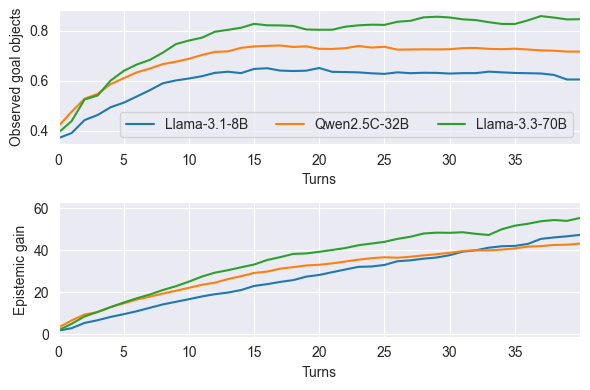

In [99]:
variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4))


metric = "known_goal_entities_ratio"

ax1.plot(get_avg_turns_score("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")
ax1.plot(get_avg_turns_score("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax1.plot(get_avg_turns_score("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
# ax1.plot(get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
# ax1.plot(get_avg_turns_score("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")

metric_name = "Observed goal objects"

ax1.set(xlabel='Turns', ylabel=f'{metric_name}',
       # title=f'Average {metric_name} over turns over all episodes'
       )
# ax.grid()

xlim = 40
ax1.set_xlim([0,xlim])
ax1.set_xticks(np.arange(0, xlim, step=5))

ax1.legend(ncols=3)


metric = "effective_epistemic_gain_amount"

ax2.plot(get_avg_turns_score_acc("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants, metric), label="Llama-3.1-8B")
ax2.plot(get_avg_turns_score_acc("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants, metric), label="Qwen2.5C-32B")
ax2.plot(get_avg_turns_score_acc("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants, metric), label="Llama-3.3-70B")
# ax2.plot(get_avg_turns_score_acc("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, metric), label="o3-mini")
# ax2.plot(get_avg_turns_score_acc("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants, metric), label="Claude3.5")

metric_name = "Epistemic gain"

ax2.set(xlabel='Turns', ylabel=f'{metric_name}',
       # title=f'Average {metric_name} over turns over all episodes'
        )
# ax.grid()

xlim = 40
plt.xlim([0,xlim])
plt.xticks(np.arange(0, xlim, step=5))

plt.tight_layout()

fig.savefig("results/exploration_epistemic_paired_vertical.pdf", format="pdf", dpi=300, bbox_inches="tight")
# fig.savefig("results/top_models_known_goal_entities_ratio_all.png")

plt.show()

#### Compound measures

In [100]:
variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

# avg_ep_acts = get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "epistemic_action")
# avg_ep_gain = get_avg_turns_score("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants, "effective_epistemic_gain_amount")

In [101]:
def get_epistemic_effect(model_id: str, variants: list):
    avg_ep_acts = get_avg_turns_score(model_id, variants, "epistemic_action")
    avg_ep_gain = get_avg_turns_score(model_id, variants, "effective_epistemic_gain_amount")

    ep_effect_compound = avg_ep_acts * avg_ep_gain

    return ep_effect_compound

In [102]:
def get_epistemic_effect_progress_list(model_id: str, variant: str, episode: str):
    ep_acts = get_score_progress_list(model_id, variant, episode, "epistemic_action")
    print(ep_acts)
    ep_gain = get_score_progress_list(model_id, variant, episode, "effective_epistemic_gain_amount")
    print(ep_gain)

    epistemic_effect_progression = ep_acts * ep_gain

    return epistemic_effect_progression

In [103]:
# get_epistemic_effect_progress_list("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", "0_home_deliver_three_basic_easy", "episode_0")

In [104]:
def get_avg_turns_score(model_id: str, variants: list, score: str):
    episodes = [f"episode_{number}" for number in range(0,16)]
    list_of_arrays = list()
    for variant in variants:
        for episode in episodes:
            score_progress_list = get_score_progress_list(model_id, variant, episode, score)
            prog_array = np.full(50, np.nan)
            for idx, val in enumerate(score_progress_list):
                prog_array[idx] = val
            list_of_arrays.append(prog_array)

    progress_array = np.array(list_of_arrays)
    averages_array = np.nanmean(progress_array, axis=0)

    return averages_array

epistemic_action not in turn 21 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 6_home_deliver_three_basic_hard episode_5
effective_epistemic_gain_amount not in turn 21 of Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0 6_home_deliver_three_basic_hard episode_5
epistemic_action not in turn 22 of Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0 14_new-words_created_basic_hard episode_2
effective_epistemic_gain_amount not in turn 22 of Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0 14_new-words_created_basic_hard episode_2


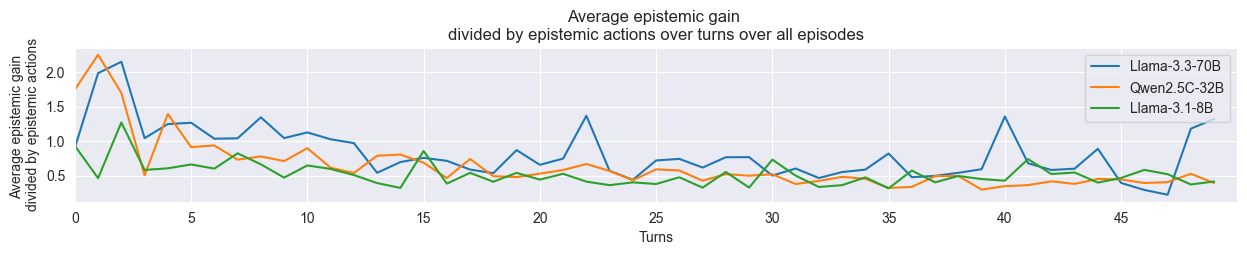

In [105]:
variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

fig, ax = plt.subplots(figsize=(15, 2))

# ax.plot(get_epistemic_effect("o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0", variants), label="o3-mini")
# ax.plot(get_epistemic_effect("claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0", variants), label="Claude3.5")
ax.plot(get_epistemic_effect("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", variants), label="Llama-3.3-70B")
ax.plot(get_epistemic_effect("Qwen2.5-Coder-32B-Instruct-t0.0--Qwen2.5-Coder-32B-Instruct-t0.0", variants), label="Qwen2.5C-32B")
ax.plot(get_epistemic_effect("Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0", variants), label="Llama-3.1-8B")

metric_name = "epistemic gain \ndivided by epistemic actions"

ax.set(xlabel='Turns', ylabel=f'Average {metric_name}',
       title=f'Average {metric_name} over turns over all episodes'
       )
# ax.grid()

plt.xlim([0,50])
plt.xticks(np.arange(0, 50, step=5))

plt.legend()

plot_tag = "epistemic_compound"
fig.savefig(f"results/top_models_{plot_tag}_all.pdf", format="pdf", bbox_inches="tight")
fig.savefig(f"results/top_models_{plot_tag}_all.png")

plt.show()

### old

In [106]:
# get single episode for exploration line plot
# model_id = "openchat_3.5-GGUF-q8-t0.0--openchat_3.5-GGUF-q8-t0.0"
model_id = 'Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0'
variant = "0_home_deliver_three_basic_easy"
# variant = "2_home_deliver_three_basic_easy_invlimittwo"
# episode = "episode_0"
episode = "episode_2"
with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
    scores = json.load(scores_file)
turn_scores = scores['turn scores']
turns_epistemic = [score_values['epistemic_action'] for score_values in turn_scores.values()]
turns_pragmatic = [score_values['pragmatic_action'] for score_values in turn_scores.values()]
turns_epistemic_gain = [score_values['effective_epistemic_gain_amount'] for score_values in turn_scores.values()]
turns_goal_score = [score_values['goal_score'] for score_values in turn_scores.values()]
turns_resolution_fail = [score_values['action_resolution_fail'] for score_values in turn_scores.values()]
turns_parsing_fail = [score_values['action_parsing_fail'] for score_values in turn_scores.values()]

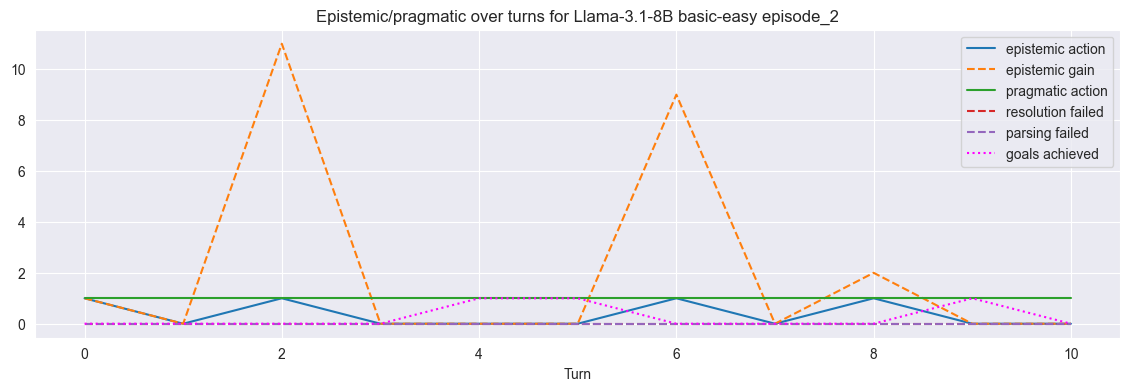

In [107]:
fig, ax = plt.subplots(figsize=(14, 4))

# ax.plot(turns_known_entities_ratio)
ax.plot(turns_epistemic)
ax.plot(turns_epistemic_gain, linestyle='dashed')
ax.plot(turns_pragmatic)
ax.plot(turns_resolution_fail, linestyle='dashed')
ax.plot(turns_parsing_fail, linestyle='dashed')
ax.plot(turns_goal_score, linestyle='dotted', color='magenta')

ax.set(xlabel='Turn',
       title=f'Epistemic/pragmatic over turns for {model_name_dict[model_id]} {experiment_short_name_dict[variant]} {episode}')
# ax.grid()
ax.legend(['epistemic action', 'epistemic gain', 'pragmatic action', 'resolution failed', 'parsing failed', 'goals achieved'], loc='upper right')

# fig.savefig("test.png")
plt.show()

### Average turns and epistemic/pragmatic actions

In [108]:
# get single episode for exploration line plot
# model_id = "openchat_3.5-GGUF-q8-t0.0--openchat_3.5-GGUF-q8-t0.0"
model_id = 'Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0'
# variant = "0_home_deliver_three_basic_easy"
variant = "4_home_deliver_three_basic_easy_invlimittwo"
# episode = "episode_0"
episode = "episode_2"
with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
    scores = json.load(scores_file)

In [109]:
def get_score_over_episodes(model_id, variant, score):
    all_episodes = list()
    if os.path.exists(f"results/{model_id}"):
        for ep_num in range(0,16):
            episode = f"episode_{ep_num}"
            # print(variant, episode)
            episode_score_list = list()
            with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
                scores = json.load(scores_file)
                # print("scores:", scores)
                ep_turn_scores = scores['turn scores']
                for turn_number, turn_dict in ep_turn_scores.items():
                    # print("turn number:", turn_number)
                    # in some cases the score might be missing on the last turn:
                    if score in turn_dict:
                        episode_score_list.append(turn_dict[score])
                all_episodes.append(episode_score_list)
        return all_episodes
    else:
        return []


In [110]:
epistemic_action_counts = get_score_over_episodes(model_id, variant, "epistemic_action")
epistemic_action_counts

[[1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  0,
  0],
 [1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0],
 [1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0],
 [1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  0],
 [1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0],
 [1,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  1,
  1],
 [1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0],
 [1,
  0,
  1,
  0,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 [1,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
  1,
  1,
  0,
  1,
  0,
 

In [111]:
numbers_of_turns = [len(episode_turns) for episode_turns in epistemic_action_counts]
numbers_of_turns

[30, 22, 11, 28, 20, 50, 18, 27, 50, 50, 25, 21, 41, 26, 21, 50]

In [112]:
numbers_of_epistemic_actions = [sum(episode_turns) for episode_turns in epistemic_action_counts]
numbers_of_epistemic_actions

[14, 12, 4, 16, 12, 25, 9, 10, 33, 32, 13, 10, 23, 10, 11, 33]

In [113]:
average_number_of_turns = np.average(numbers_of_turns)
average_number_of_turns

30.625

In [114]:
average_number_of_epistemic_actions = np.average(numbers_of_epistemic_actions)
average_number_of_epistemic_actions

16.6875

In [115]:
def get_average_score_over_experiments(model_id, score):
    variant_turns_average = list()
    variant_score_averages = list()
    for variant in experiment_short_name_dict.keys():
        variant_scores = get_score_over_episodes(model_id, variant, score)
        numbers_of_turns = [len(episode_turns) for episode_turns in variant_scores]
        numbers_of_scores = [sum(episode_turns) for episode_turns in variant_scores]
        average_number_of_turns = np.average(numbers_of_turns)
        variant_turns_average.append(average_number_of_turns)
        average_number_of_scores = np.average(numbers_of_scores)
        variant_score_averages.append(average_number_of_scores)
    return variant_turns_average, variant_score_averages


In [116]:
# get_average_score_over_experiments(model_id, "epistemic_action")

In [117]:
get_average_score_over_experiments("Llama-3.3-70B-Instruct-t0.0--Llama-3.3-70B-Instruct-t0.0", "epistemic_action")

([15.5,
  13.25,
  17.0,
  14.0,
  20.5625,
  17.5625,
  27.625,
  30.9375,
  31.5,
  27.6875,
  29.6875,
  30.0625,
  23.4375,
  41.6875,
  23.4375],
 [8.4375,
  6.0625,
  9.125,
  6.625,
  11.25,
  9.25,
  18.75,
  22.3125,
  21.8125,
  19.0625,
  18.375,
  18.3125,
  14.3125,
  22.4375,
  8.6875])

In [118]:
# get averages for all models
def get_average_epistemic_all(model_names = None):
    avg_turns_list = list()
    avg_epistemic_gain_list = list()
    avg_epistemic_actions_list = list()
    avg_plan_viability_list = list()

    if not model_names:
        model_names = model_name_dict.keys()

    for model_id in model_names:
        print(model_id)
        avg_epistemic_scores_tuple = get_average_score_over_experiments(model_id, "effective_epistemic_gain_amount")
        avg_turns = avg_epistemic_scores_tuple[0]
        # print("avg_turns", avg_turns)
        avg_turns_overall = np.average(avg_epistemic_scores_tuple[0])
        # print("avg_turns_overall", avg_turns_overall)
        if not np.isnan(avg_turns_overall):
            avg_turns_list.append(avg_turns_overall)
        avg_epistemic_gain = avg_epistemic_scores_tuple[1]
        avg_epistemic_gain_overall = np.average(avg_epistemic_scores_tuple[1])
        if not np.isnan(avg_epistemic_gain_overall):
            avg_epistemic_gain_list.append(avg_epistemic_gain_overall)
        avg_epistemic_scores_tuple = get_average_score_over_experiments(model_id, "epistemic_action")
        avg_epistemic_actions = avg_epistemic_scores_tuple[1]
        avg_epistemic_actions_overall = np.average(avg_epistemic_scores_tuple[1])
        if not np.isnan(avg_epistemic_actions_overall):
            avg_epistemic_actions_list.append(avg_epistemic_actions_overall)
        avg_plan_viability_tuple = get_average_score_over_experiments(model_id, "plan_command_success_ratio")
        avg_plan_viability = avg_plan_viability_tuple[1]
        avg_plan_viability_overall = np.average(avg_plan_viability_tuple[1])
        if not np.isnan(avg_plan_viability_overall):
            avg_plan_viability_list.append(avg_plan_viability_overall)
    return avg_turns_list, avg_epistemic_gain_list, avg_epistemic_actions_list, avg_plan_viability_list

In [119]:
# avg_turns_list, avg_epistemic_gain_list, avg_epistemic_actions_list, avg_plan_viability_list = get_average_epistemic_all(top_models)
# print(avg_turns_list)
# print(avg_epistemic_gain_list)
# print(avg_epistemic_actions_list)
# print(avg_plan_viability_list)

# Misc episode detection

In [120]:
def get_turn_score_progressions(model_id: str, variants: list, score: str):
    episodes = [f"episode_{number}" for number in range(0,16)]
    # list_of_arrays = list()
    progs_dict = dict()
    for variant in variants:
        progs_dict[variant] = dict()
        for episode in episodes:
            score_progress_list = get_score_progress_list(model_id, variant, episode, score)
            prog_array = np.full(50, np.nan)
            for idx, val in enumerate(score_progress_list):
                prog_array[idx] = val
            # list_of_arrays.append(prog_array)
            progs_dict[variant][episode] = prog_array
    # progress_array = np.array(list_of_arrays)
    # averages_array = np.nanmean(progress_array, axis=0)

    return progs_dict

In [121]:
def detect_best_earliest_score(prog_dict: dict, turn_offset_factor: float = 0.1):
    best_eps = list()
    best_score = 0
    best_earliest_eps = list()
    best_earliest_score = 0
    for variant, episodes in prog_dict.items():
        for ep_id, progression in episodes.items():
            for turn_idx in range(50):
                turn_score = progression[turn_idx]
                if turn_score > best_score:
                    best_ep = f"{variant} {ep_id} turn {turn_idx}"
                    best_eps.append(best_ep)
                    best_score = turn_score

                turn_lateness_offset = turn_idx * turn_offset_factor
                turn_offset_score = turn_score - turn_lateness_offset
                if turn_offset_score > best_earliest_score:
                    best_earliest_ep = f"{variant} {ep_id} turn {turn_idx}"
                    best_earliest_eps.append(best_earliest_ep)
                    best_earliest_score = turn_offset_score

    return best_eps, best_earliest_eps

In [122]:
# detect_best_earliest_score(o3_plan_progs, turn_offset_factor=0.01)

In [123]:
def detect_best_long_plan(prog_dict: dict, model_id: str):
    best_longest_eps = list()
    best_score = 0
    longest_plan = 0
    highest_go = 0
    for variant, episodes in prog_dict.items():
        for ep_id, progression in episodes.items():

            # load interactions:
            with open(f"results/{model_id}/adventuregame/{variant}/{ep_id}/interactions.json", 'r', encoding='utf-8') as interactions_file:
                ep_interactions = json.load(interactions_file)

            # for turn_idx, turn_acts in enumerate(ep_interactions['turns']):

            ep_plan_lengths = list()
            ep_plan_go_count = list()

            for turn_acts in ep_interactions['turns']:
                for turn_act in turn_acts:
                    if turn_act['action']['type'] == 'plan_length':
                        ep_plan_lengths.append(turn_act['action']['content'])
                    if turn_act['action']['type'] == 'current_plan':
                        go_count = 0
                        split_plan = turn_act['action']['content'][1:-1].replace("'", "").split(", ")
                        # for planned_action in turn_act['action']['content']:
                        for planned_action in split_plan:
                            # print(planned_action)
                            # "go" | "enter" | "return" | "proceed" | "move\
                            if planned_action.startswith(('go', 'move', 'enter', 'return', 'proceed')):
                                go_count += 1
                        ep_plan_go_count.append(go_count)

            # print(variant, ep_id, ep_plan_go_count)

            # print(ep_plan_lengths)

            for turn_idx in range(50):
                long = False
                more_go = False
                if turn_idx < len(ep_plan_lengths):
                    turn_score = progression[turn_idx]
                    if ep_plan_lengths[turn_idx] >= longest_plan:
                        long = True
                        longest_plan = ep_plan_lengths[turn_idx]

                    if ep_plan_go_count[turn_idx] > highest_go:
                        more_go = True
                        highest_go = ep_plan_go_count[turn_idx]

                    plan_turn_score = ep_plan_lengths[turn_idx] * turn_score

                    # if long and more_go and turn_score > best_score:
                    if plan_turn_score > best_score:
                        # if long and plan_turn_score > best_score:
                        best_ep = f"{variant} {ep_id} turn {turn_idx}"
                        best_longest_eps.append(best_ep)
                        # best_score = turn_score
                        best_score = plan_turn_score

    print(best_score, longest_plan)

    return best_longest_eps

In [124]:
# detect_best_long_plan(o3_plan_progs, "o3-mini-2025-01-31-t0.0--o3-mini-2025-01-31-t0.0")

## Navigation

In [125]:
variants = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
# "2_home_deliver_three_planning_easy",
# "3_home_deliver_three_planning_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
# "5_home_deliver_three_planning_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
# "8_home_deliver_three_planning_hard",
# "9_home_deliver_three_planning_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
# "11_home_deliver_three_planning_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

# claude_nav_progs = get_turn_score_progressions('claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0', variants, "no_exit_to")

In [126]:
def detect_nav_fail_correction(prog_dict: dict, model_id: str):
    corrected_eps = list()
    bad_eps = list()
    double_nav_fails = list()
    prime_examples = list()
    for variant, episodes in prog_dict.items():
        for ep_id, progression in episodes.items():
            single_fail = False
            single_fail_turn = int()

            nav_fail_sum = np.nansum(progression)
            if not 2 > nav_fail_sum > 0:
                single_fail = True

            if nav_fail_sum > 5:
                bad_eps.append(f"{variant} {ep_id}")

            for turn_idx in range(50):
                turn_score = progression[turn_idx]
                if turn_score == 1:
                    # check if next turn is a nav fail too
                    if turn_idx+1 < 50 and progression[turn_idx+1] == 1:
                        double_nav_fails.append(f"{variant} {ep_id}")
                    if single_fail:
                        single_fail_turn = turn_idx

            if not single_fail:
                continue

            # load interactions:
            with open(f"results/{model_id}/adventuregame/{variant}/{ep_id}/interactions.json", 'r', encoding='utf-8') as interactions_file:
                ep_interactions = json.load(interactions_file)

            correct_go_turns = list()

            for turn_idx, turn_acts in enumerate(ep_interactions['turns']):
                for turn_act in turn_acts:
                    if turn_act['action']['type'] == 'action_info':
                        act_content = turn_act['action']['content']
                        if act_content['action_type'] == "go":
                            correct_go_turns.append(turn_idx)

            for later_turn in range(single_fail_turn, len(ep_interactions['turns'])):
                cur_ep = f"{variant} {ep_id}"
                if later_turn in correct_go_turns and cur_ep not in corrected_eps:
                    corrected_eps.append(f"{variant} {ep_id}")

            if single_fail_turn+1 in correct_go_turns and single_fail_turn+2 in correct_go_turns and single_fail_turn+3 in correct_go_turns:
                prime_examples.append(f"{variant} {ep_id} turn {single_fail_turn}")



    return {'corrected': corrected_eps, 'bad': bad_eps, 'double_fails': double_nav_fails, 'prime_examples': prime_examples}

In [127]:
# detect_nav_fail_correction(claude_nav_progs, 'claude-3-5-sonnet-20241022-t0.0--claude-3-5-sonnet-20241022-t0.0')

# Speed

In [128]:
# get single episode for turn count

model_id = 'Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0'
variant = "0_home_deliver_three_basic_easy"

episode = "episode_2"
with open(f"results/{model_id}/adventuregame/{variant}/{episode}/scores.json") as scores_file:
    scores = json.load(scores_file)
turn_scores = scores['turn scores']
len(turn_scores)

11

In [129]:
def get_turn_values_model_experiment(model_id, experiment):
    episodes = [f"episode_{number}" for number in range(0,16)]
    model_experiment_turns: list = list()
    for episode in episodes:
        # get turn count:
        with open(f"results/{model_id}/adventuregame/{experiment}/{episode}/scores.json") as scores_file:
            scores = json.load(scores_file)
        turns_taken = len(scores['turn scores'])
        # get optimal turns:
        with open(f"results/{model_id}/adventuregame/{experiment}/{episode}/instance.json") as instance_file:
            instance = json.load(instance_file)
        optimal_turns = instance['optimal_turns']
        # dict and append:
        turns_dict: dict = {'turns_taken': turns_taken, 'optimal_turns': optimal_turns}
        model_experiment_turns.append(turns_dict)
    return model_experiment_turns

In [ ]:
def get_turn_values_model_experiment_successful(model_id, experiment):
    """get turn values for successful episodes only"""
    episodes = [f"episode_{number}" for number in range(0,16)]
    model_experiment_turns: list = list()
    for episode in episodes:
        # get turn count:
        with open(f"results/{model_id}/adventuregame/{experiment}/{episode}/scores.json") as scores_file:
            scores = json.load(scores_file)
        if not scores["episode scores"]["Success"] == 1:
            continue
        turns_taken = len(scores['turn scores'])
        # get optimal turns:
        with open(f"results/{model_id}/adventuregame/{experiment}/{episode}/instance.json") as instance_file:
            instance = json.load(instance_file)
        optimal_turns = instance['optimal_turns']
        # dict and append:
        turns_dict: dict = {'turns_taken': turns_taken, 'optimal_turns': optimal_turns}
        model_experiment_turns.append(turns_dict)
    return model_experiment_turns

In [130]:
model_id = 'Meta-Llama-3.1-8B-Instruct-t0.0--Meta-Llama-3.1-8B-Instruct-t0.0'
experiment = "0_home_deliver_three_basic_easy"
get_turn_values_model_experiment(model_id, experiment)

[{'turns_taken': 18, 'optimal_turns': 10},
 {'turns_taken': 35, 'optimal_turns': 12},
 {'turns_taken': 11, 'optimal_turns': 8},
 {'turns_taken': 50, 'optimal_turns': 14},
 {'turns_taken': 13, 'optimal_turns': 11},
 {'turns_taken': 50, 'optimal_turns': 13},
 {'turns_taken': 19, 'optimal_turns': 10},
 {'turns_taken': 34, 'optimal_turns': 10},
 {'turns_taken': 50, 'optimal_turns': 11},
 {'turns_taken': 50, 'optimal_turns': 11},
 {'turns_taken': 17, 'optimal_turns': 10},
 {'turns_taken': 17, 'optimal_turns': 10},
 {'turns_taken': 50, 'optimal_turns': 10},
 {'turns_taken': 50, 'optimal_turns': 15},
 {'turns_taken': 17, 'optimal_turns': 14},
 {'turns_taken': 17, 'optimal_turns': 16}]

In [133]:
def get_turn_values_experiment_all_models(experiment):
    all_models_experiment_turns: dict = dict()
    for model_id in final_models:
        all_models_experiment_turns[model_name_dict[model_id]] = get_turn_values_model_experiment(model_id, experiment)
    return all_models_experiment_turns

In [134]:
get_turn_values_experiment_all_models("0_home_deliver_three_basic_easy")

{'Llama-3.1-70B': [{'turns_taken': 10, 'optimal_turns': 10},
  {'turns_taken': 17, 'optimal_turns': 12},
  {'turns_taken': 10, 'optimal_turns': 8},
  {'turns_taken': 18, 'optimal_turns': 14},
  {'turns_taken': 14, 'optimal_turns': 11},
  {'turns_taken': 16, 'optimal_turns': 13},
  {'turns_taken': 13, 'optimal_turns': 10},
  {'turns_taken': 17, 'optimal_turns': 10},
  {'turns_taken': 14, 'optimal_turns': 11},
  {'turns_taken': 14, 'optimal_turns': 11},
  {'turns_taken': 11, 'optimal_turns': 10},
  {'turns_taken': 14, 'optimal_turns': 10},
  {'turns_taken': 11, 'optimal_turns': 10},
  {'turns_taken': 13, 'optimal_turns': 15},
  {'turns_taken': 11, 'optimal_turns': 14},
  {'turns_taken': 14, 'optimal_turns': 16}],
 'Llama-3.3-70B': [{'turns_taken': 10, 'optimal_turns': 10},
  {'turns_taken': 19, 'optimal_turns': 12},
  {'turns_taken': 10, 'optimal_turns': 8},
  {'turns_taken': 20, 'optimal_turns': 14},
  {'turns_taken': 16, 'optimal_turns': 11},
  {'turns_taken': 21, 'optimal_turns': 13},

In [204]:
experiments = ["0_home_deliver_three_basic_easy",
"1_home_deliver_three_basic_preexplore_easy",
"4_home_deliver_three_basic_easy_invlimittwo",
"6_home_deliver_three_basic_hard",
"7_home_deliver_three_basic_preexplore_hard",
"10_home_deliver_three_basic_hard_invlimittwo",
"12_new-words_home-delivery_easy_basic_easy",
"13_new-words_home-delivery_medium_basic_medium",
"14_new-words_created_basic_hard"]

def get_turn_values_all():
    all_turn_values: dict = dict()
    for experiment in experiments:
        all_turn_values[experiment_short_name_dict[experiment]] = get_turn_values_experiment_all_models(experiment)
    return all_turn_values

In [205]:
all_turn_values_dict = get_turn_values_all()
all_turn_values_dict

{'basic-easy': {'Claude-3.7': [{'turns_taken': 10, 'optimal_turns': 10},
   {'turns_taken': 17, 'optimal_turns': 12},
   {'turns_taken': 10, 'optimal_turns': 8},
   {'turns_taken': 18, 'optimal_turns': 14},
   {'turns_taken': 13, 'optimal_turns': 11},
   {'turns_taken': 16, 'optimal_turns': 13},
   {'turns_taken': 15, 'optimal_turns': 10},
   {'turns_taken': 17, 'optimal_turns': 10},
   {'turns_taken': 17, 'optimal_turns': 11},
   {'turns_taken': 13, 'optimal_turns': 11},
   {'turns_taken': 18, 'optimal_turns': 10},
   {'turns_taken': 13, 'optimal_turns': 10},
   {'turns_taken': 15, 'optimal_turns': 10},
   {'turns_taken': 18, 'optimal_turns': 15},
   {'turns_taken': 11, 'optimal_turns': 14},
   {'turns_taken': 13, 'optimal_turns': 16}],
  'o3-mini': [{'turns_taken': 13, 'optimal_turns': 10},
   {'turns_taken': 15, 'optimal_turns': 12},
   {'turns_taken': 12, 'optimal_turns': 8},
   {'turns_taken': 50, 'optimal_turns': 14},
   {'turns_taken': 16, 'optimal_turns': 11},
   {'turns_taken'

In [206]:
# get turns taken list -> min max, error bars etc

In [207]:
def get_average_turns_taken(all_turn_values_dict):
    avg_dict: dict = dict()
    for exp, models in all_turn_values_dict.items():
        #print(exp, models)
        avg_dict[exp] = dict()
        for model, model_turns_list in models.items():
            # print(model_turns_list)
            turns_taken_list = [ep_turns['turns_taken'] for ep_turns in model_turns_list]
            # print(turns_taken_list)
            avg_turns = average(turns_taken_list)
            # print(avg_turns)
            avg_dict[exp][model] = avg_turns

            optimal_turns_list = [ep_turns['optimal_turns'] for ep_turns in model_turns_list]
            avg_optimal = average(optimal_turns_list)
            avg_dict[exp]['optimal'] = avg_optimal
            # break
        # break
    return avg_dict

In [208]:
get_average_turns_taken(all_turn_values_dict)

{'basic-easy': {'Claude-3.7': 14.625,
  'optimal': 11.5625,
  'o3-mini': 21.375,
  'GPT-4o': 14.3125,
  'Llama-3.1-70B': 13.5625,
  'Llama-3.3-70B': 15.5,
  'DeepSeek-V3': 14.375,
  'Qwen2.5-32B': 22.5625,
  'Qwen2-72B': 32.6875,
  'Qwen2.5-72B': 33.6875,
  'Llama-3.1-8B': 31.125},
 'basic-easy-preexp': {'Claude-3.7': 12.5625,
  'optimal': 11.5625,
  'o3-mini': 14.875,
  'GPT-4o': 14.875,
  'Llama-3.1-70B': 13.5,
  'Llama-3.3-70B': 13.25,
  'DeepSeek-V3': 14.5,
  'Qwen2.5-32B': 22.1875,
  'Qwen2-72B': 16.4375,
  'Qwen2.5-72B': 23.6875,
  'Llama-3.1-8B': 17.5625},
 'basic-easy-invlimit': {'Claude-3.7': 14.625,
  'optimal': 11.5625,
  'o3-mini': 16.0625,
  'GPT-4o': 14.25,
  'Llama-3.1-70B': 17.9375,
  'Llama-3.3-70B': 20.5625,
  'DeepSeek-V3': 15.8125,
  'Qwen2.5-32B': 28.5625,
  'Qwen2-72B': 23.8125,
  'Qwen2.5-72B': 23.5,
  'Llama-3.1-8B': 30.625},
 'basic-hard': {'Claude-3.7': 26.75,
  'optimal': 19.1875,
  'o3-mini': 27.1875,
  'GPT-4o': 31.5625,
  'Llama-3.1-70B': 29.875,
  'Llama-

In [276]:
"""
experiment_categories = {
    "basic": ["basic-easy", "basic-hard"],
    "preexplore": ["basic-easy-preexp", "basic-hard-preexp"],
    "invlimit": ["basic-easy-invlimit", "basic-hard-invlimit"],
    "new-words": ["new-words-easy", "new-words-medium", "new-words-hard"]
}
"""

experiment_categories = {
    "Basic": ["basic-easy", "basic-hard"],
    "Pre-exploration": ["basic-easy-preexp", "basic-hard-preexp"],
    "Inventory limit": ["basic-easy-invlimit", "basic-hard-invlimit"],
    "Synthetic words": ["new-words-easy", "new-words-medium", "new-words-hard"]
}

def get_average_turns_taken_grouped(all_turn_values_dict):
    avg_dict: dict = dict()
    for experiment_category in experiment_categories:
        # print(experiment_category)
        avg_dict[experiment_category] = dict()
        for exp, models in all_turn_values_dict.items():
            # print(exp, models)
            if exp not in experiment_categories[experiment_category]:
                # print(f"{exp} not in {experiment_categories[experiment_category]}")
                continue
            for model, model_turns_list in models.items():
                # print(model_turns_list)
                turns_taken_list = [ep_turns['turns_taken'] for ep_turns in model_turns_list]
                # print(turns_taken_list)
                avg_turns = average(turns_taken_list)
                # print(avg_turns)
                if model not in avg_dict[experiment_category]:
                    # avg_dict[experiment_category][model] = [avg_turns]
                    avg_dict[experiment_category][model] = turns_taken_list
                else:
                    # avg_dict[experiment_category][model].append(avg_turns)
                    avg_dict[experiment_category][model] += turns_taken_list

                optimal_turns_list = [ep_turns['optimal_turns'] for ep_turns in model_turns_list]
                avg_optimal = average(optimal_turns_list)
                avg_dict[experiment_category]['optimal'] = avg_optimal
                # break
            # break
        for model, turns_taken in avg_dict[experiment_category].items():
            # print(model, turns_taken)
            avg_dict[experiment_category][model] = average(turns_taken)

    return avg_dict

get_average_turns_taken_grouped(all_turn_values_dict)

{'Basic': {'Claude-3.7': 20.6875,
  'optimal': 19.1875,
  'o3-mini': 24.28125,
  'GPT-4o': 22.9375,
  'Llama-3.1-70B': 21.71875,
  'Llama-3.3-70B': 21.59375,
  'DeepSeek-V3': 23.3125,
  'Qwen2.5-32B': 33.03125,
  'Qwen2-72B': 38.9375,
  'Qwen2.5-72B': 39.53125,
  'Llama-3.1-8B': 38.46875},
 'Pre-exploration': {'Claude-3.7': 18.6875,
  'optimal': 19.1875,
  'o3-mini': 21.84375,
  'GPT-4o': 22.5625,
  'Llama-3.1-70B': 20.9375,
  'Llama-3.3-70B': 22.09375,
  'DeepSeek-V3': 26.125,
  'Qwen2.5-32B': 33.375,
  'Qwen2-72B': 29.21875,
  'Qwen2.5-72B': 31.84375,
  'Llama-3.1-8B': 30.34375},
 'Inventory limit': {'Claude-3.7': 20.59375,
  'optimal': 19.1875,
  'o3-mini': 21.78125,
  'GPT-4o': 25.15625,
  'Llama-3.1-70B': 24.40625,
  'Llama-3.3-70B': 25.125,
  'DeepSeek-V3': 27.875,
  'Qwen2.5-32B': 36.75,
  'Qwen2-72B': 32.3125,
  'Qwen2.5-72B': 33.65625,
  'Llama-3.1-8B': 37.4375},
 'Synthetic words': {'Claude-3.7': 22.854166666666668,
  'optimal': 6.0,
  'o3-mini': 31.395833333333332,
  'GPT-4o

In [291]:
# speed_df = pd.DataFrame.from_dict(get_average_turns_taken(all_turn_values_dict), orient='index')
# speed_df = pd.DataFrame.from_dict(get_average_turns_taken(all_turn_values_dict))
speed_df = pd.DataFrame.from_dict(get_average_turns_taken_grouped(all_turn_values_dict))
# speed_df_no_opt = speed_df.drop('optimal')
speed_df_no_opt = speed_df.drop('optimal').rename({
    "Llama-3.1-70B": "LM3.1-70B",
    "Llama-3.1-8B": "LM3.1-8B",
    "Llama-3.3-70B": "LM3.3-70B",
    "Claude-3.7": "Cl",
    "DeepSeek-V3": "DS",
    "Qwen2.5-32B": "Q2.5-32B",
    "Qwen2.5-72B": "Q2.5-72B",
    "Qwen2-72B": "Q2-72B"
})
# speed_df
speed_df_no_opt

,Basic,Pre-exploration,Inventory limit,Synthetic words
Cl,20.68750,18.68750,20.59375,22.854167
o3-mini,24.28125,21.84375,21.78125,31.395833
GPT-4o,22.93750,22.56250,25.15625,23.250000
LM3.1-70B,21.71875,20.93750,24.40625,30.041667
LM3.3-70B,21.59375,22.09375,25.12500,29.520833
DS,23.31250,26.12500,27.87500,22.833333
Q2.5-32B,33.03125,33.37500,36.75000,41.250000
Q2-72B,38.93750,29.21875,32.31250,34.979167
Q2.5-72B,39.53125,31.84375,33.65625,36.708333
LM3.1-8B,38.46875,30.34375,37.43750,28.333333


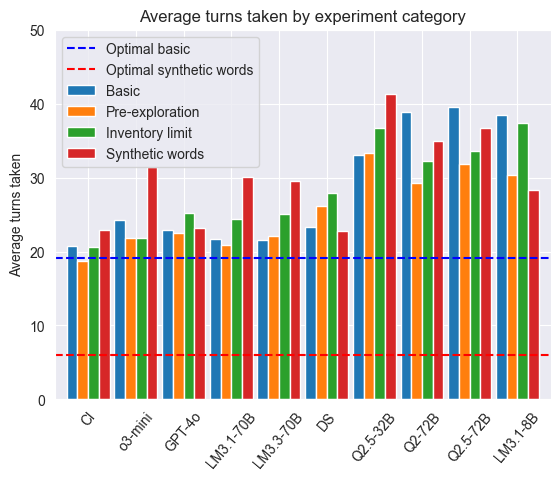

In [311]:
# ax = speed_df[['Claude-3.7', 'o3-mini', 'GPT-4o', 'Llama-3.1-70B', 'Llama-3.3-70B', 'Llama-3.1-8B', 'DeepSeek-V3', 'Qwen2-72B', 'Qwen2.5-32B', 'Qwen2.5-72B']].plot.bar(figsize=(14, 4), width=0.9)
# ax = speed_df_no_opt.plot.bar(figsize=(14, 4), width=0.7)
ax = speed_df_no_opt.plot.bar(width=0.9)
# speed_df['optimal'].plot.line(ax=ax)
ax.set_ylabel("Average turns taken")
# ax.plot(19.1875)

plt.axhline(y=19.1875, color='blue', linestyle="--", label="Optimal basic")
plt.axhline(y=6.0, color='red', linestyle="--", label="Optimal synthetic words")

# plt.legend(loc='upper left', ncols=2)
plt.legend(loc='upper left')
# plt.legend(loc='upper left', nrows=3)
plt.ylim(0, 50)

# plt.xticks(rotation=0)
plt.xticks(rotation=50)

plt.title("Average turns taken by experiment category")
# plt.ylabel = "Turns taken"

plt.savefig("results/speed_plot_all.pdf", format="pdf", bbox_inches="tight")

In [304]:
speed_df_only_best = speed_df_no_opt.drop(['Q2.5-32B', 'Q2-72B', 'Q2.5-72B', 'LM3.1-8B']).rename({'LM3.1-70B': 'LM3.1', 'LM3.3-70B': 'LM3.3'})

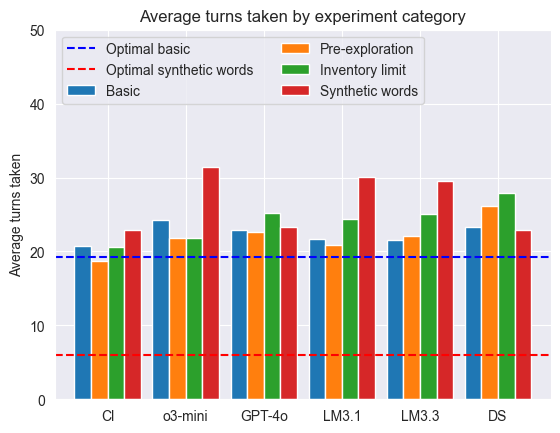

In [310]:
ax = speed_df_only_best.plot.bar(width=0.85)
# speed_df['optimal'].plot.line(ax=ax)
ax.set_ylabel("Average turns taken")
# ax.plot(19.1875)

plt.axhline(y=19.1875, color='blue', linestyle="--", label="Optimal basic")
plt.axhline(y=6.0, color='red', linestyle="--", label="Optimal synthetic words")

plt.legend(loc='upper left', ncols=2)
# plt.legend(loc='upper left')
# plt.legend(loc='upper left', nrows=3)
plt.ylim(0, 50)

plt.xticks(rotation=0)
# plt.xticks(rotation=50)

plt.title("Average turns taken by experiment category")
# plt.ylabel = "Turns taken"

plt.savefig("results/speed_plot_selected.pdf", format="pdf", bbox_inches="tight")